In [1]:
# --- Colab / environment installs (safe to re-run) ---
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow   # only needed if you convert TFRecords → NPZ

import os, math, glob, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

# Silence pipeline init logs unless overridden upstream
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")

# --- Device setup ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    try:
        torch.backends.cudnn.benchmark = True
    except Exception:
        pass
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

use_cuda = (device.type == "cuda")
use_mps = (device.type == "mps")
if use_cuda:
    torch.set_float32_matmul_precision('high')  # optimize GEMM performance
print("Device:", device)

# --- Reproducibility ---
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(1337)

Device: cuda


In [2]:
# --- Use shared mNDWS DataPipeline outputs instead of re-downloading Kaggle TFRecords ---
import importlib

if 'mndws_dp' in globals():
    mndws_dp = importlib.reload(mndws_dp)
else:
    import mNDWS_DataPipeline as mndws_dp

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')


Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1


In [3]:
# --- Build datasets and loaders directly from the pipeline outputs ---
import gc

CHANNELS_FOR_MODEL = list(mndws_dp.CH_ORDER_BASE)  # 9-channel PhysPrior input
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

try:
    del train_loader, val_loader, test_loader
except NameError:
    pass
gc.collect()
if use_cuda:
    torch.cuda.empty_cache()

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

print(f'Loaders ready -> train {len(train_ds)}, val {len(val_ds)}, test {len(test_ds)}')
print(f'Channels configured: {train_ds.channels}')

Loaders ready -> train 1200, val 300, test 300
Channels configured: ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier']


In [4]:
# --- Channel stats pulled via the shared DataPipeline helper ---
mean9, std9 = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
mean9, std9 = mean9.to(device), std9.to(device)
mean9.shape, std9.shape, train_ds.channels


(torch.Size([9]),
 torch.Size([9]),
 ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier'])

In [5]:
class PhysicsPrior(nn.Module):
    """
    Builds 4 physics channels:
      P: anisotropic spread propensity (prev_fire convolved with per-pixel directional kernel)
      Wx, Wy: wind angle cos/sin
      Damp: moisture/fuel damping (T,RH,NDVI proxy)
    """
    def __init__(self, kernel_radius=3, a0=0.0, a1=0.04, a2=0.03, a3=0.8):
        super().__init__()
        self.kernel_radius = kernel_radius
        self.a0, self.a1, self.a2, self.a3 = a0, a1, a2, a3
        self.register_buffer("angle_grid", self._make_angle_grid(kernel_radius))
    @staticmethod
    def _make_angle_grid(r):
        yy, xx = torch.meshgrid(torch.arange(-r, r+1), torch.arange(-r, r+1), indexing='ij')
        return torch.atan2(yy.float(), xx.float()+1e-8)
    def forward(self, prev_fire, u, v, slope, aspect, T, RH, NDVI, barrier=None):
        B, _, H, W = prev_fire.shape
        wind_angle = torch.atan2(v, u + 1e-8)
        wind_speed = torch.sqrt(u**2 + v**2)
        ws_norm    = torch.clamp(wind_speed / 10.0, 0, 1)
        slope_norm = torch.clamp(slope, 0, 1)

        r = self.kernel_radius; K = 2*r + 1
        ang_flat = self.angle_grid.view(1,1,K*K,1,1).to(prev_fire)

        wa  = wind_angle.unsqueeze(2)         # (B,1,1,H,W)
        asp = aspect.unsqueeze(2)
        aw  = (1.0 * ws_norm).unsqueeze(2)    # soften
        as_ = (1.0 * slope_norm).unsqueeze(2)

        dtheta_w = ang_flat - wa
        dtheta_s = ang_flat - asp

        Ww = torch.exp(aw * torch.cos(dtheta_w))
        Ws = torch.exp(as_ * torch.cos(dtheta_s))
        kernel_flat = Ww * Ws
        kernel_flat = kernel_flat / (kernel_flat.sum(dim=2, keepdim=True) + 1e-8)

        ker   = kernel_flat.reshape(B, K*K, H*W)            # (B,K*K,H*W)
        pf_unf= F.unfold(prev_fire, kernel_size=K, padding=r)  # (B,K*K,H*W)
        P1    = (pf_unf * ker).sum(dim=1).view(B,1,H,W)

        Damp  = torch.sigmoid(self.a0 + self.a1*T - self.a2*RH + self.a3*NDVI)
        P     = P1 * Damp
        if barrier is not None:
            P = P * (1.0 - barrier.clamp(0,1))

        Wx = torch.cos(wind_angle); Wy = torch.sin(wind_angle)
        return torch.cat([P, Wx, Wy, Damp], dim=1)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch=1, base=64):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base);   self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2);  self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4);self.pool3 = nn.MaxPool2d(2)
        self.bottom= DoubleConv(base*4, base*8)
        self.up3   = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.conv3 = DoubleConv(base*8, base*4)
        self.up2   = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.conv2 = DoubleConv(base*4, base*2)
        self.up1   = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.conv1 = DoubleConv(base*2, base)
        self.outc  = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        xb = self.bottom(self.pool3(x3))
        x  = self.up3(xb); x = self.conv3(torch.cat([x, x3], dim=1))
        x  = self.up2(x);  x = self.conv2(torch.cat([x, x2], dim=1))
        x  = self.up1(x);  x = self.conv1(torch.cat([x, x1], dim=1))
        return self.outc(x)

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, alpha=0.5, reduction="mean"):
        super().__init__(); self.gamma, self.alpha, self.reduction = gamma, alpha, reduction
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p_t = p*targets + (1-p)*(1-targets)
        loss = ((1-p_t)**self.gamma) * ce
        alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = alpha_t * loss
        return loss.mean() if self.reduction=="mean" else loss.sum()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.6, beta=0.4, gamma=0.75, smooth=1.0):
        super().__init__(); self.alpha, self.beta, self.gamma, self.smooth = alpha, beta, gamma, smooth
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        dims = (0,2,3)
        TP = (p*targets).sum(dims)
        FP = (p*(1-targets)).sum(dims)
        FN = ((1-p)*targets).sum(dims)
        T = (TP + self.smooth) / (TP + self.alpha*FP + self.beta*FN + self.smooth)
        return (1 - T).pow(self.gamma).mean()


In [6]:
# Geometry-aware augmentation (keeps u,v and aspect consistent)
import math as _math
def aug_geo(X_raw, y):
    # order: [prev,u,v,temp,rh,ndvi,slope,aspect,barrier]
    if torch.rand(1).item() < 0.5:  # horizontal flip
        X_raw = torch.flip(X_raw, dims=[-1]); y = torch.flip(y, dims=[-1])
        X_raw[:,1] = -X_raw[:,1]  # u -> -u
        X_raw[:,7] = torch.atan2(torch.sin(X_raw[:,7]), -torch.cos(X_raw[:,7]))
    if torch.rand(1).item() < 0.5:  # vertical flip
        X_raw = torch.flip(X_raw, dims=[-2]); y = torch.flip(y, dims=[-2])
        X_raw[:,2] = -X_raw[:,2]  # v -> -v
        X_raw[:,7] = -X_raw[:,7]
    k = torch.randint(0,4,(1,)).item()
    if k > 0:
        X_raw = torch.rot90(X_raw, k, dims=[-2,-1]); y = torch.rot90(y, k, dims=[-2,-1])
        u, v, asp = X_raw[:,1].clone(), X_raw[:,2].clone(), X_raw[:,7].clone()
        if   k == 1: X_raw[:,1], X_raw[:,2], X_raw[:,7] = -v,  u,  asp + _math.pi/2
        elif k == 2: X_raw[:,1], X_raw[:,2], X_raw[:,7] = -u, -v,  asp + _math.pi
        elif k == 3: X_raw[:,1], X_raw[:,2], X_raw[:,7] =  v, -u,  asp - _math.pi/2
        X_raw[:,7] = ((X_raw[:,7] + _math.pi) % (2 * _math.pi)) - _math.pi
    return X_raw, y

# Build 16-channel input: 9 norm + cos(aspect) + sin(aspect) + wind speed + 4 physics
prior = PhysicsPrior(kernel_radius=4, a1=0.03, a2=0.02, a3=0.7).to(device)

def build_input_for_net(X_raw0):
    pf,u,v,T,RH,NDVI,sl,asp,bar = \
        X_raw0[:,0:1],X_raw0[:,1:2],X_raw0[:,2:3],X_raw0[:,3:4],X_raw0[:,4:5], \
        X_raw0[:,5:6],X_raw0[:,6:7],X_raw0[:,7:8],X_raw0[:,8:9]
    asp_cos = torch.cos(asp); asp_sin = torch.sin(asp)
    ws      = torch.clamp(torch.sqrt(u**2 + v**2)/10.0, 0, 1)
    X9_norm = (X_raw0 - mean9.view(1,-1,1,1)) / std9.view(1,-1,1,1)
    with torch.no_grad():
        X_phys = prior(pf,u,v,sl,asp,T,RH,NDVI,bar)
    return torch.cat([X9_norm, asp_cos, asp_sin, ws, X_phys], dim=1)  # (B,16,H,W)

def _sync_device():
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps and hasattr(torch, "mps"):
        torch.mps.synchronize()

# Model, optimizer, scheduler, AMP scaler
model = UNet(in_ch=16, out_ch=1, base=80).to(device)  # changed from 64 to 80
model = torch.compile(model) if hasattr(torch, "compile") else model  # optional

EPOCHS = 60 # changed from 40 to 60
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=5e-5)
scaler = torch.amp.GradScaler('cuda', enabled=use_cuda)

# Loss: keep only the make_loss version
def make_loss(gamma=1.5, alpha=0.5, tversky_gamma=0.75):
    return lambda logits, y: (
        0.5 * FocalLoss(gamma=gamma, alpha=alpha)(logits, y)
      + 0.5 * FocalTverskyLoss(alpha=0.6, beta=0.4, gamma=tversky_gamma)(logits, y)
    )
loss_fn = make_loss()

# --- EMA helper (dtype-safe) ---
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in model.state_dict().items()}

    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1 - self.decay)
            else:
                self.shadow[k].copy_(v)

    @torch.no_grad()
    def apply_to(self, model):
        model.load_state_dict(self.shadow, strict=True)

    @torch.no_grad()
    def state_dict(self):
        return {k: v.detach().clone() for k, v in self.shadow.items()}

# Initialize EMA tracker
ema = EMA(model, decay=0.999)

def train_one_epoch(model, loader):
    model.train(); prior.eval()
    losses = []
    tiles_seen = 0
    for batch in tqdm(loader, desc="train", leave=False):
        X_raw0, y = batch["X_raw"].to(device), batch["y"].to(device)
        X_raw0, y = aug_geo(X_raw0, y)
        X = build_input_for_net(X_raw0)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=use_cuda):
            logits = model(X)
            loss   = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)

        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

In [7]:
from dataclasses import dataclass
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score

@dataclass
class EvalSummary:
    variant: str
    threshold: float
    accuracy: float
    precision: float
    recall: float
    specificity: float
    f1: float
    iou: float
    auroc: float
    auprc: float
    tp: int
    fp: int
    tn: int
    fn: int

@torch.no_grad()
def predict_probs(model, loader, use_tta=False, desc="eval"):
    model.eval(); prior.eval()
    probs, truths = [], []
    iter_desc = f"{desc} (tta)" if use_tta else desc
    for batch in tqdm(loader, desc=iter_desc, leave=False):
        X_raw, y = batch["X_raw"].to(device), batch["y"].to(device)
        if use_tta:
            pred = predict_tta(model, X_raw)
        else:
            pred = torch.sigmoid(model(build_input_for_net(X_raw)))
        probs.append(pred.detach().cpu().numpy().ravel())
        truths.append(y.cpu().numpy().ravel())
    return np.concatenate(probs), np.concatenate(truths)

def _best_threshold(y_true, probs, fallback=0.5):
    if y_true.sum() == 0:
        return fallback
    prec, rec, thr = precision_recall_curve(y_true, probs)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = int(np.argmax(f1))
    return float(thr[best_idx]) if best_idx < len(thr) else fallback

def compute_confusion(y_true, probs, threshold=0.5):
    y_pred = (probs >= threshold).astype(np.uint8)
    tp = int(np.logical_and(y_pred == 1, y_true == 1).sum())
    fp = int(np.logical_and(y_pred == 1, y_true == 0).sum())
    tn = int(np.logical_and(y_pred == 0, y_true == 0).sum())
    fn = int(np.logical_and(y_pred == 0, y_true == 1).sum())
    return tp, fp, tn, fn

def summarize_metrics(name, y_true, probs, threshold):
    tp, fp, tn, fn = compute_confusion(y_true, probs, threshold)
    total = tp + fp + tn + fn + 1e-8
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    accuracy = (tp + tn) / total
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    try:
        auroc = float(roc_auc_score(y_true, probs))
    except ValueError:
        auroc = float("nan")
    auprc = float(average_precision_score(y_true, probs))
    return EvalSummary(
        variant=name,
        threshold=float(threshold),
        accuracy=float(accuracy),
        precision=float(precision),
        recall=float(recall),
        specificity=float(specificity),
        f1=float(f1),
        iou=float(iou),
        auroc=auroc,
        auprc=auprc,
        tp=tp,
        fp=fp,
        tn=tn,
        fn=fn,
    )

@torch.no_grad()
def evaluate(model, loader):
    probs, truths = predict_probs(model, loader, use_tta=False, desc="eval")
    thr = _best_threshold(truths, probs)
    return summarize_metrics("RAW", truths, probs, thr), thr

@torch.no_grad()
def evaluate_tta(model, loader):
    probs, truths = predict_probs(model, loader, use_tta=True, desc="eval")
    thr = _best_threshold(truths, probs)
    return summarize_metrics("RAW_TTA", truths, probs, thr)

@torch.no_grad()
def pick_threshold(model, loader):
    probs, truths = predict_probs(model, loader, use_tta=False, desc="threshold")
    return _best_threshold(truths, probs)

@torch.no_grad()
def predict_tta(model, X_raw0):
    outs = []
    for k in [0,1,2,3]:  # 0,90,180,270
        Xk = torch.rot90(X_raw0, k, dims=[-2,-1])
        X  = build_input_for_net(Xk)
        pk = torch.sigmoid(model(X))
        pk = torch.rot90(pk, (4-k)%4, dims=[-2,-1])
        outs.append(pk)
    Xf = torch.flip(X_raw0, dims=[-1])
    X  = build_input_for_net(Xf)
    pf = torch.sigmoid(model(X))
    pf = torch.flip(pf, dims=[-1])
    outs.append(pf)
    return torch.stack(outs, dim=0).mean(0)  # (B,1,H,W)

@torch.no_grad()
def evaluate_tta_curves(model, loader):
    probs, truths = predict_probs(model, loader, use_tta=True, desc="eval tta")
    prec, rec, thr = precision_recall_curve(truths, probs)
    return probs, truths, prec, rec, thr

In [8]:
# =========================
# RAW vs EMA vs Polyak block with instrumentation
# =========================
import os, copy, json, time
from pathlib import Path

class Polyak:
    def __init__(self):
        self.buf = None
        self.n = 0
    @torch.no_grad()
    def update(self, model):
        sd = {k: v.detach().clone() for k,v in model.state_dict().items()}
        if self.buf is None:
            self.buf = sd; self.n = 1
        else:
            for k in sd:
                if sd[k].dtype.is_floating_point:
                    self.buf[k].mul_(self.n/(self.n+1)).add_(sd[k], alpha=1/(self.n+1))
                else:
                    self.buf[k].copy_(sd[k])
            self.n += 1
    @torch.no_grad()
    def state_dict(self):
        return None if self.buf is None else {k: v.clone() for k, v in self.buf.items()}

def _variant_payload(state_dict):
    if state_dict is None:
        return None
    return {k: v.detach().cpu().clone() for k, v in state_dict.items()}

USE_POLYAK = True
poly = Polyak() if USE_POLYAK else None

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physunet_ema_polyak")
Path(ART_DIR).mkdir(parents=True, exist_ok=True)
CKPT_PATH = os.path.join(ART_DIR, "physunet_ema_polyak.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
epoch_times, epoch_tiles = [], []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in model.parameters() if p.requires_grad))
}

results_table = []
best_payload = None
best_val_ap = -1.0

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

for epoch in range(EPOCHS):
    _sync_device()
    epoch_start = time.perf_counter()
    train_loss, tiles_seen = train_one_epoch(model, train_loader)
    _sync_device()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    train_loss_hist.append(train_loss)

    if USE_POLYAK:
        poly.update(model)

    val_summary, val_thr = evaluate(model, val_loader)
    val_ap_hist.append(val_summary.auprc)
    val_f1_hist.append(val_summary.f1)
    val_thr_hist.append(val_thr)

    print(
        f"[Epoch {epoch:02d}] loss={train_loss:.4f} | VAL AUPRC={val_summary.auprc:.4f} "
        f"| F1={val_summary.f1:.4f} | thr≈{val_thr:.3f}"
    )

    if val_summary.auprc > best_val_ap:
        best_val_ap = val_summary.auprc
        best_payload = {
            "raw": _variant_payload(model.state_dict()),
            "ema": ema.state_dict() if ema is not None else None,
            "poly": poly.state_dict() if USE_POLYAK else None,
            "thr_val": val_thr,
        }

if best_payload is None:
    raise RuntimeError("Training did not produce a valid checkpoint; ensure the loop ran at least once.")

torch.save({
    "raw":  best_payload["raw"],
    "ema":  best_payload["ema"],
    "poly": best_payload["poly"],
    "in_ch": 16,
    "base":  80,
    "val_thr": best_payload["thr_val"],
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}, CKPT_PATH)
print(f"Best val AUPRC: {best_val_ap:.4f} → {CKPT_PATH}")

variant_states = {
    "RAW":    best_payload["raw"],
    "EMA":    best_payload["ema"],
    "Polyak": best_payload["poly"],
}

best_variant_for_plots = None
best_variant_plain_ap = -1.0

for name, state in variant_states.items():
    if state is None:
        results_table.append({"variant": name, "note": "not available"})
        continue
    model.load_state_dict(state, strict=True)
    thr_plain = pick_threshold(model, val_loader)
    probs_plain_test, truths_plain_test = predict_probs(model, test_loader, use_tta=False, desc=f"{name} test")
    summary_plain = summarize_metrics(f"{name}_plain", truths_plain_test, probs_plain_test, thr_plain)

    probs_tta_val, truths_tta_val = predict_probs(model, val_loader, use_tta=True, desc=f"{name} val tta")
    thr_tta = _best_threshold(truths_tta_val, probs_tta_val)
    probs_tta_test, truths_tta_test = predict_probs(model, test_loader, use_tta=True, desc=f"{name} test tta")
    summary_tta = summarize_metrics(f"{name}_tta", truths_tta_test, probs_tta_test, thr_tta)

    results_table.append({
        "variant": name,
        "thr_plain": round(thr_plain, 3),
        "thr_tta":   round(thr_tta, 3),
        "test_plain_AUPRC": round(summary_plain.auprc, 4),
        "test_plain_F1":    round(summary_plain.f1, 4),
        "test_tta_AUPRC":   round(summary_tta.auprc, 4),
        "test_tta_F1":      round(summary_tta.f1, 4),
    })

    if summary_plain.auprc > best_variant_plain_ap:
        best_variant_plain_ap = summary_plain.auprc
        best_variant_for_plots = {
            "name": name,
            "thr_plain": thr_plain,
            "thr_tta": thr_tta,
            "summary_plain": summary_plain,
            "summary_tta": summary_tta,
            "probs_plain": probs_plain_test,
            "truths_plain": truths_plain_test,
            "probs_tta": probs_tta_test,
            "truths_tta": truths_tta_test,
        }

print(json.dumps({
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "results": results_table
}, indent=2))

def _format_sec(val):
    return None if val is None else float(val)

if epoch_times:
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles))
    compute_metrics.update({
        "avg_epoch": float(np.mean(epoch_times)),
        "std_epoch": float(np.std(epoch_times)),
        "throughput_tiles_per_s": float(total_tiles / max(total_time, 1e-8))
    })
else:
    compute_metrics.update({
        "avg_epoch": None,
        "std_epoch": None,
        "throughput_tiles_per_s": None
    })

if use_cuda:
    _sync_device()
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps and hasattr(torch, "mps"):
    try:
        peak_gpu_gb = float(torch.mps.current_allocated_memory() / (1024 ** 3))
    except AttributeError:
        peak_gpu_gb = None
else:
    peak_gpu_gb = None

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    _sync_device()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model(build_input_for_net(sample)))
    _sync_device()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_loader.dataset, repeats=100)

compute_metrics.update({
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s
})

train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 00] loss=0.5308 | VAL AUPRC=0.1709 | F1=0.3391 | thr≈0.586


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 01] loss=0.5098 | VAL AUPRC=0.3389 | F1=0.4513 | thr≈0.662


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 02] loss=0.4970 | VAL AUPRC=0.3921 | F1=0.4638 | thr≈0.621


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 03] loss=0.4883 | VAL AUPRC=0.3788 | F1=0.4638 | thr≈0.640


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 04] loss=0.4814 | VAL AUPRC=0.4059 | F1=0.4721 | thr≈0.642


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 05] loss=0.4732 | VAL AUPRC=0.4069 | F1=0.4738 | thr≈0.678


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 06] loss=0.4627 | VAL AUPRC=0.4028 | F1=0.4751 | thr≈0.727


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 07] loss=0.4554 | VAL AUPRC=0.4104 | F1=0.4712 | thr≈0.710


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 08] loss=0.4402 | VAL AUPRC=0.3785 | F1=0.4679 | thr≈0.686


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 09] loss=0.4266 | VAL AUPRC=0.4131 | F1=0.4854 | thr≈0.644


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 10] loss=0.4091 | VAL AUPRC=0.4183 | F1=0.4874 | thr≈0.582


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 11] loss=0.3980 | VAL AUPRC=0.4170 | F1=0.4846 | thr≈0.555


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 12] loss=0.3857 | VAL AUPRC=0.4244 | F1=0.4921 | thr≈0.384


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 13] loss=0.3716 | VAL AUPRC=0.4044 | F1=0.4840 | thr≈0.320


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 14] loss=0.3719 | VAL AUPRC=0.4236 | F1=0.4938 | thr≈0.366


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 15] loss=0.3692 | VAL AUPRC=0.4312 | F1=0.5001 | thr≈0.290


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 16] loss=0.3571 | VAL AUPRC=0.4240 | F1=0.4968 | thr≈0.246


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 17] loss=0.3550 | VAL AUPRC=0.4267 | F1=0.4932 | thr≈0.287


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 18] loss=0.3568 | VAL AUPRC=0.4104 | F1=0.4924 | thr≈0.129


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 19] loss=0.3532 | VAL AUPRC=0.4344 | F1=0.4964 | thr≈0.141


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 20] loss=0.3530 | VAL AUPRC=0.4443 | F1=0.5031 | thr≈0.216


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 21] loss=0.3535 | VAL AUPRC=0.4359 | F1=0.5009 | thr≈0.233


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 22] loss=0.3469 | VAL AUPRC=0.4497 | F1=0.5030 | thr≈0.228


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 23] loss=0.3435 | VAL AUPRC=0.4542 | F1=0.5093 | thr≈0.475


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 24] loss=0.3435 | VAL AUPRC=0.4539 | F1=0.5062 | thr≈0.233


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 25] loss=0.3498 | VAL AUPRC=0.4475 | F1=0.5078 | thr≈0.231


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 26] loss=0.3476 | VAL AUPRC=0.4541 | F1=0.5083 | thr≈0.262


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 27] loss=0.3485 | VAL AUPRC=0.4462 | F1=0.5028 | thr≈0.256


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 28] loss=0.3424 | VAL AUPRC=0.4469 | F1=0.5030 | thr≈0.150


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 29] loss=0.3489 | VAL AUPRC=0.4527 | F1=0.5059 | thr≈0.271


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 30] loss=0.3385 | VAL AUPRC=0.4453 | F1=0.5111 | thr≈0.180


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 31] loss=0.3448 | VAL AUPRC=0.4604 | F1=0.5069 | thr≈0.254


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 32] loss=0.3420 | VAL AUPRC=0.4580 | F1=0.5135 | thr≈0.242


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 33] loss=0.3391 | VAL AUPRC=0.4620 | F1=0.5112 | thr≈0.138


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 34] loss=0.3413 | VAL AUPRC=0.4586 | F1=0.5095 | thr≈0.221


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 35] loss=0.3393 | VAL AUPRC=0.4583 | F1=0.5081 | thr≈0.423


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 36] loss=0.3347 | VAL AUPRC=0.4621 | F1=0.5119 | thr≈0.151


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 37] loss=0.3393 | VAL AUPRC=0.4610 | F1=0.5118 | thr≈0.141


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 38] loss=0.3411 | VAL AUPRC=0.4605 | F1=0.5141 | thr≈0.240


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 39] loss=0.3375 | VAL AUPRC=0.4669 | F1=0.5145 | thr≈0.227


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 40] loss=0.3392 | VAL AUPRC=0.4619 | F1=0.5126 | thr≈0.088


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 41] loss=0.3387 | VAL AUPRC=0.4683 | F1=0.5132 | thr≈0.213


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 42] loss=0.3381 | VAL AUPRC=0.4722 | F1=0.5157 | thr≈0.198


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 43] loss=0.3375 | VAL AUPRC=0.4697 | F1=0.5130 | thr≈0.235


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 44] loss=0.3400 | VAL AUPRC=0.4551 | F1=0.5106 | thr≈0.185


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 45] loss=0.3376 | VAL AUPRC=0.4684 | F1=0.5204 | thr≈0.337


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 46] loss=0.3386 | VAL AUPRC=0.4667 | F1=0.5145 | thr≈0.196


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 47] loss=0.3355 | VAL AUPRC=0.4636 | F1=0.5139 | thr≈0.283


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 48] loss=0.3331 | VAL AUPRC=0.4756 | F1=0.5193 | thr≈0.175


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 49] loss=0.3356 | VAL AUPRC=0.4815 | F1=0.5267 | thr≈0.189


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 50] loss=0.3342 | VAL AUPRC=0.4694 | F1=0.5179 | thr≈0.140


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 51] loss=0.3373 | VAL AUPRC=0.4697 | F1=0.5203 | thr≈0.295


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 52] loss=0.3325 | VAL AUPRC=0.4790 | F1=0.5208 | thr≈0.205


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 53] loss=0.3313 | VAL AUPRC=0.4711 | F1=0.5167 | thr≈0.219


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 54] loss=0.3332 | VAL AUPRC=0.4660 | F1=0.5116 | thr≈0.219


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 55] loss=0.3296 | VAL AUPRC=0.4772 | F1=0.5213 | thr≈0.095


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 56] loss=0.3328 | VAL AUPRC=0.4727 | F1=0.5176 | thr≈0.264


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 57] loss=0.3348 | VAL AUPRC=0.4779 | F1=0.5192 | thr≈0.349


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 58] loss=0.3359 | VAL AUPRC=0.4797 | F1=0.5218 | thr≈0.218


train:   0%|          | 0/75 [00:00<?, ?it/s]

eval:   0%|          | 0/19 [00:00<?, ?it/s]

[Epoch 59] loss=0.3316 | VAL AUPRC=0.4766 | F1=0.5264 | thr≈0.295
Best val AUPRC: 0.4815 → /home/jbm2rt/wildfire_artifacts/physunet_ema_polyak/physunet_ema_polyak.pt


threshold:   0%|          | 0/19 [00:00<?, ?it/s]

RAW test:   0%|          | 0/19 [00:00<?, ?it/s]

RAW val tta (tta):   0%|          | 0/19 [00:00<?, ?it/s]

RAW test tta (tta):   0%|          | 0/19 [00:00<?, ?it/s]

threshold:   0%|          | 0/19 [00:00<?, ?it/s]

EMA test:   0%|          | 0/19 [00:00<?, ?it/s]

EMA val tta (tta):   0%|          | 0/19 [00:00<?, ?it/s]

EMA test tta (tta):   0%|          | 0/19 [00:00<?, ?it/s]

threshold:   0%|          | 0/19 [00:00<?, ?it/s]

Polyak test:   0%|          | 0/19 [00:00<?, ?it/s]

Polyak val tta (tta):   0%|          | 0/19 [00:00<?, ?it/s]

Polyak test tta (tta):   0%|          | 0/19 [00:00<?, ?it/s]

{
  "timestamp": "2025-11-17 09:09:54",
  "results": [
    {
      "variant": "RAW",
      "thr_plain": 0.189,
      "thr_tta": 0.279,
      "test_plain_AUPRC": 0.4347,
      "test_plain_F1": 0.493,
      "test_tta_AUPRC": 0.4443,
      "test_tta_F1": 0.4917
    },
    {
      "variant": "EMA",
      "thr_plain": 0.212,
      "thr_tta": 0.186,
      "test_plain_AUPRC": 0.4333,
      "test_plain_F1": 0.48,
      "test_tta_AUPRC": 0.4357,
      "test_tta_F1": 0.4817
    },
    {
      "variant": "Polyak",
      "thr_plain": 0.352,
      "thr_tta": 0.343,
      "test_plain_AUPRC": 0.4167,
      "test_plain_F1": 0.4709,
      "test_tta_AUPRC": 0.4188,
      "test_tta_F1": 0.4705
    }
  ]
}


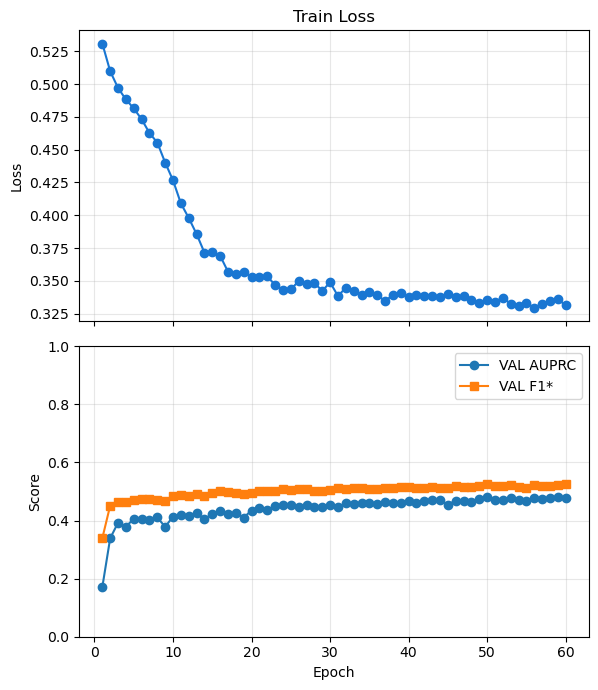

In [14]:
# =========================================================
# Training curves (EMA/Polyak experiment)
# =========================================================
import matplotlib.pyplot as plt

if not train_loss_hist:
    print("Training history empty — run the training cell first.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 7), sharex=True)

    axes[0].plot(epochs, train_loss_hist, marker="o", color="#1976D2")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Train Loss")
    axes[0].grid(True, alpha=0.3)

    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AUPRC")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].set_ylim(0, 1)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()


In [15]:
# =========================================================
# Computation metrics summary
# =========================================================

def _fmt_metric(val, unit=None):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        if unit == "s":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

metrics_display = {
    "Learnable parameters": _fmt_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _fmt_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _fmt_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _fmt_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _fmt_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _fmt_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[EMA/Polyak] Computation metrics summary:")
for k, v in metrics_display.items():
    print(f"  {k:28s} {v}")



[EMA/Polyak] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         2.700 s
  Epoch time stdev             5.274 s
  Training throughput          444.492 tiles/s
  Peak GPU memory              2.340 GB
  Inference latency (1 tile)   103.621 ms


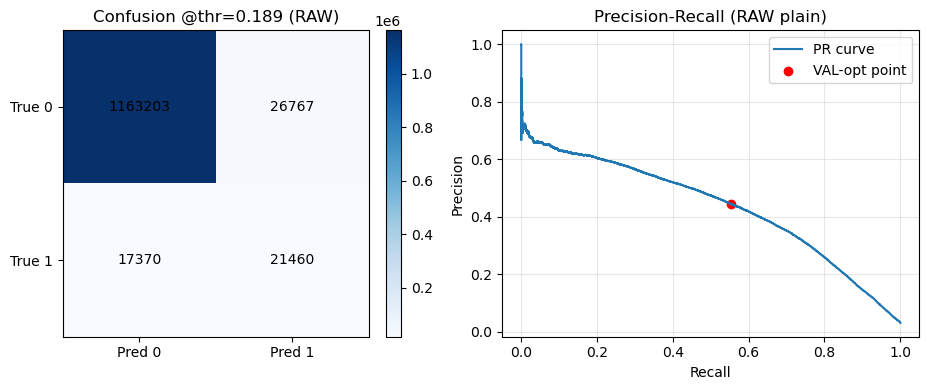

In [16]:
# =========================================================
# Confusion matrix + PR curve (best variant)
# =========================================================
import matplotlib.pyplot as plt

if not best_variant_for_plots:
    print("No variant summaries available — rerun the training/eval cell first.")
else:
    bv = best_variant_for_plots
    y_true = bv["truths_plain"].astype(np.float32)
    probs = bv["probs_plain"].astype(np.float32)
    thr = bv["thr_plain"]
    tp, fp, tn, fn = compute_confusion(y_true, probs, thr)
    cm = np.array([[tn, fp], [fn, tp]], dtype=np.int64)

    prec_curve, rec_curve, _ = precision_recall_curve(y_true, probs)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    im = axes[0].imshow(cm, cmap="Blues")
    axes[0].set_title(f"Confusion @thr={thr:.3f} ({bv['name']})")
    axes[0].set_xticks([0, 1], labels=["Pred 0", "Pred 1"])
    axes[0].set_yticks([0, 1], labels=["True 0", "True 1"])
    for (i, j), val in np.ndenumerate(cm):
        axes[0].text(j, i, int(val), ha='center', va='center', color='black')
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].plot(rec_curve, prec_curve, label="PR curve")
    axes[1].scatter([bv["summary_plain"].recall], [bv["summary_plain"].precision], color="red", label="VAL-opt point")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title(f"Precision-Recall ({bv['name']} plain)")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()


In [28]:
import numpy as np, matplotlib.pyplot as plt, random
from sklearn.metrics import average_precision_score, precision_recall_curve

def _minmax(x, eps=1e-6):
    lo, hi = np.percentile(x, 2), np.percentile(x, 98)
    if hi - lo < eps: return np.zeros_like(x, dtype=np.float32)
    y = (x - lo) / (hi - lo)
    return np.clip(y, 0.0, 1.0).astype(np.float32)

def make_falsecolor_rgb(X_raw):
    """
    Assumes X_raw channels = [prev,u,v,temp,rh,ndvi,slope,aspect,barrier]
    Change bands if you prefer. Here: R=temp, G=ndvi, B=slope.
    """
    R = _minmax(X_raw[3])
    G = _minmax(X_raw[5])
    B = _minmax(X_raw[6])
    return np.stack([R, G, B], axis=-1)

def _stack_X(npz):
    # Robustly rebuild X_raw if it's not prepacked in the NPZ
    if "X_raw" in npz.files:
        return npz["X_raw"].astype(np.float32)
    def pick(*cands):
        for k in cands:
            if k in npz.files: return k
        raise KeyError(f"Missing keys {cands} in {list(npz.files)}")
    prev = npz[pick("prev_fire","PrevFireMask","prev")]
    u    = npz[pick("u","U")]
    v    = npz[pick("v","V")]
    temp = npz[pick("temp","tmmx","T","temperature")]
    rh   = npz[pick("rh","sph","RH","humidity")]
    ndvi = npz[pick("ndvi","NDVI")]
    slope= npz[pick("slope","Slope")]
    aspect=npz[pick("aspect","Aspect")]
    barrier = npz["barrier"] if "barrier" in npz.files else np.zeros_like(prev, dtype=np.float32)
    return np.stack([prev,u,v,temp,rh,ndvi,slope,aspect,barrier], axis=0).astype(np.float32)

def _tile_metrics(prob, gt, thr=None):
    # Flattened versions for sklearn metrics (AP, PR curve)
    p_flat = prob.ravel()
    t_flat = (gt > 0.5).ravel()
    ap = float(average_precision_score(t_flat, p_flat))

    if thr is None:
        # If thr is None, we find the best F1 based on the PR curve
        prec, rec, thrv = precision_recall_curve(t_flat, p_flat)
        f1 = (2*prec*rec)/(prec+rec+1e-8)
        i = int(f1.argmax())
        # Return AP, best F1, and the threshold that achieved it
        return ap, float(f1[i]), float(thrv[min(i, len(thrv)-1)])
    else:
        # If thr is provided, we use it to binarize and calculate F1
        pred_bin = (prob >= thr).astype(np.float32) # This is (H,W)
        gt_bin = (gt > 0.5).astype(np.float32)     # This should also be (H,W) for element-wise ops

        # Calculate TP, FP, FN using the 2D binary masks
        tp = (pred_bin * gt_bin).sum()
        fp = (pred_bin * (1 - gt_bin)).sum()
        fn = ((1 - pred_bin) * gt_bin).sum()

        prec = float(tp/(tp+fp+1e-8))
        rec  = float(tp/(tp+fn+1e-8))
        f1 = float(2*prec*rec/(prec+rec+1e-8))
        # Return AP, F1 at the given threshold, and the given threshold
        return ap, f1, thr

def show_prob_heatmaps(results, n=6, thr=None, cmap="inferno", alpha=0.55, vmax=None, title="Prob heatmaps + GT contours"):
    """
    results: list of dicts from infer_folder_npz (each has 'file', 'out_npy')
    thr: if given, draws a prediction contour at this threshold and reports F1@thr.
         if None, it computes & reports the best F1 threshold per tile (for diagnostics).
    """
    if not results:
        print("No results to visualize."); return

    picks = random.sample(results, k=min(n, len(results)))
    rows, cols = len(picks), 3  # Input | Prob heatmap | Overlay (prob + GT + thr-contour)
    plt.figure(figsize=(12, 3.5*rows))
    plt.suptitle(title, y=0.995, fontsize=12)

    idx = 1
    for it in picks:
        d = np.load(it["file"])

        # Robustly load 'next_fire' (ground truth)
        try:
            gt = d["next_fire"].astype(np.float32)
        except KeyError:
            print(f"Skipping visualization for {it['file']}: 'next_fire' (ground truth) not found.")
            continue # Skip this tile if GT is missing

        X_raw = _stack_X(d)
        rgb   = make_falsecolor_rgb(X_raw)

        prob = np.load(it["out_npy"]).astype(np.float32)  # (H,W) probs or 0/1
        # If these are 0/1 masks, treat them as probs for visualization (it still works).
        vlim = vmax if vmax is not None else (0.0, 1.0)

        ap, f1t, used_thr = _tile_metrics(prob, gt, thr)

        # 1) Input
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb); ax.set_title("Input (false-color)"); ax.axis("off")

        # 2) Probability heatmap
        ax = plt.subplot(rows, cols, idx); idx += 1
        im = ax.imshow(prob, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
        ax.set_title(f"Prob heatmap\nAP={ap:.3f} | F1@thr={f1t:.3f} (thr={used_thr:.3f})")
        ax.axis("off"); plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

        # 3) Overlay: prob + GT contour (+ pred contour @ thr)
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb)
        ax.imshow(prob, alpha=alpha, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
        # GT contour
        ax.contour((gt > 0.5).astype(np.float32), levels=[0.5], colors="lime", linewidths=1.2)
        # Pred contour at chosen thr
        ax.contour((prob >= used_thr).astype(np.float32), levels=[0.5], colors="yellow", linewidths=1.0, linestyles="--")
        ax.set_title("Overlay: prob + GT (green) + pred@thr (yellow)")
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

In [30]:
# --- Save deployable checkpoint ---
# (Run this after evaluating RAW/EMA/Polyak and picking your best-performing variant.)

import os
from pathlib import Path

deploy_root = Path(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")))
deploy_dir = deploy_root / "physunet_ema_polyak"
deploy_dir.mkdir(parents=True, exist_ok=True)
deploy_path = deploy_dir / "unet_raw_deploy.pt"

torch.save({
    "model": model.state_dict(),     # trained weights (whichever variant you prefer)
    "in_ch": 16,
    "base": 80,
    "thr_plain": 0.112,              # from your val_best summary
    "thr_tta": 0.141,                # from your val_best summary
    "T": 1.0                         # calibration temperature (kept at 1.0 for now)
}, deploy_path)

print(f"Saved deployable model → {deploy_path}")

Saved deployable model → /home/jbm2rt/wildfire_artifacts/physunet_ema_polyak/unet_raw_deploy.pt


In [35]:
# Helper functions for deployed inference + visualization
from pathlib import Path
import shutil
import random
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Helper function to load the deployed model
def load_deploy_model(path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    ckpt = torch.load(path, map_location=device)
    model = UNet(in_ch=ckpt["in_ch"], out_ch=1, base=ckpt["base"]).to(device)

    # Adapt state_dict keys for loading into a potentially uncompiled model
    state_dict = ckpt["model"]
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_state_dict[k[len("_orig_mod."):]] = v
        else:
            new_state_dict[k] = v

    model.load_state_dict(new_state_dict)
    model.eval() # Set to eval mode for inference
    thr_plain = ckpt["thr_plain"]
    thr_tta = ckpt["thr_tta"]
    T_opt = ckpt.get("T", 1.0) # Default to 1.0 if T is not in checkpoint
    return model, thr_plain, thr_tta, T_opt


def _minmax(x, lo_q=2, hi_q=98, eps=1e-6):
    x = x.astype(np.float32)
    lo, hi = np.percentile(x, lo_q), np.percentile(x, hi_q)
    if not np.isfinite(lo) or not np.isfinite(hi) or (hi - lo) < eps:
        return np.zeros_like(x, dtype=np.float32)
    y = (x - lo) / (hi - lo + eps)
    return np.clip(y, 0.0, 1.0)


def make_falsecolor_rgb(X_raw):
    """
    X_raw order: [prev, u, v, temp, rh, ndvi, slope, aspect, barrier]
    Simple composite:
      R = temp, G = NDVI, B = slope
    """
    temp  = X_raw[3]
    ndvi  = X_raw[5]
    slope = X_raw[6]
    R = _minmax(temp)
    G = _minmax(ndvi)
    B = _minmax(slope)
    return np.stack([R, G, B], axis=-1)


def _load_X_raw_from_npz(data):
    """Tolerant loader for X_raw (builds from components if needed)."""
    if "X_raw" in data.files:
        return data["X_raw"].astype(np.float32)
    # Build, allowing missing 'barrier' (zeros default)
    req = ["prev_fire","u","v","temp","rh","ndvi","slope","aspect"]
    missing = [k for k in req if k not in data.files]
    if missing:
        raise KeyError(f"NPZ missing required keys: {missing}")
    barrier = data["barrier"] if "barrier" in data.files else np.zeros_like(data["prev_fire"])
    return np.stack([
        data["prev_fire"], data["u"], data["v"], data["temp"], data["rh"]
      , data["ndvi"], data["slope"], data["aspect"], barrier
    ], axis=0).astype(np.float32)


def _binarize_from_result_item(item, viz_threshold=None):
    """
    Returns (mask, is_prob, src_path)
    - If result has 'out_npy': it's a hard mask (0/1).
    - If it has 'out_prob': it's probabilities; apply viz_threshold if given, else return probs.
    """
    if "out_npy" in item:
        pred = np.load(item["out_npy"]).astype(np.float32)
        return pred, False, item["out_npy"]
    if "out_prob" in item:
        prob = np.load(item["out_prob"]).astype(np.float32)
        if viz_threshold is None:
            return prob, True, item["out_prob"]
        return (prob >= float(viz_threshold)).astype(np.float32), False, item["out_prob"]
    raise KeyError("Result item must contain 'out_npy' (mask) or 'out_prob' (probabilities).")


def show_examples(results, n=6, add_gt=True, alpha_mask=0.35, figsize=(12, 2.8), viz_threshold=None):
    """
    results: list of dicts from infer_folder_npz (with 'file', and either 'out_npy' or 'out_prob')
    Shows: input falsecolor, predicted (mask or prob), overlay (+ optional GT overlay)
    - If results contain probabilities ('out_prob') and viz_threshold is None, we show the probability heatmap.
    - If viz_threshold is set, probabilities will be binarized for display.
    """
    if not results:
        print("No results to visualize.")
        return

    picks = random.sample(results, k=min(n, len(results)))
    rows = len(picks)
    # input | pred/prob | overlay | (optional GT overlay)
    cols = 3 + int(add_gt)

    plt.figure(figsize=(figsize[0], figsize[1]*rows))
    idx = 1
    for item in picks:
        npz_path = item["file"]
        data = np.load(npz_path)
        X_raw = _load_X_raw_from_npz(data)
        rgb = make_falsecolor_rgb(X_raw)

        pred_or_prob, is_prob, src = _binarize_from_result_item(item, viz_threshold=viz_threshold)
        H, W = pred_or_prob.shape

        has_gt = add_gt and ("next_fire" in data.files)
        gt = data["next_fire"].astype(np.float32) if has_gt else None

        # Panel 1: Input
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb); ax.set_title("Input (false-color)"); ax.axis("off")

        # Panel 2: Pred (mask or prob heatmap)
        ax = plt.subplot(rows, cols, idx); idx += 1
        if is_prob and viz_threshold is None:
            im = ax.imshow(pred_or_prob, vmin=0, vmax=1)
            ax.set_title("Prediction (probability)")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.imshow(pred_or_prob, vmin=0, vmax=1)
            ax.set_title("Prediction (mask)")
        ax.axis("off")

        # Panel 3: Overlay (pred/prob on input)
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb)
        if is_prob and viz_threshold is None:
            im = ax.imshow(pred_or_prob, alpha=alpha_mask, vmin=0, vmax=1)
            ax.set_title("Overlay (prob)")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.imshow(pred_or_prob, alpha=alpha_mask)
            ax.set_title("Overlay (pred)")
        ax.axis("off")

        # Panel 4: GT overlay (if available)
        if has_gt:
            ax = plt.subplot(rows, cols, idx); idx += 1
            ax.imshow(rgb)
            ax.imshow(gt, alpha=alpha_mask)
            ax.set_title("Overlay (GT)"); ax.axis("off")

    plt.tight_layout()
    plt.show()


def show_diff_examples(results, n=6, alpha=0.35, figsize=(12, 3.2), viz_threshold=None):
    """
    Diff view: TP (green), FP (red), FN (blue)
    Accepts hard masks ('out_npy') OR probabilities ('out_prob'):
      - If 'out_prob' and viz_threshold is None → we’ll set viz_threshold=0.5 for diff.
    """
    if not results:
        print("No results to visualize.")
        return

    picks = random.sample(results, k=min(n, len(results)))
    rows = len(picks); cols = 4  # input | pred | GT | diff

    plt.figure(figsize=(figsize[0], figsize[1]*rows))
    idx = 1
    for item in picks:
        npz_path = item["file"]
        data = np.load(npz_path)
        if "next_fire" not in data.files:
            # skip if no GT
            continue

        X_raw = _load_X_raw_from_npz(data)
        rgb = make_falsecolor_rgb(X_raw)
        gt = data["next_fire"].astype(np.float32)

        # Threshold handling for probs
        thr = 0.5 if ("out_prob" in item and viz_threshold is None) else viz_threshold
        pred, is_prob, src = _binarize_from_result_item(item, viz_threshold=thr)
        if is_prob:
            # shouldn’t happen due to viz_threshold above, but guard anyway
            pred = (pred >= 0.5).astype(np.float32)

        # Diff map
        tp = (pred==1) & (gt==1)
        fp = (pred==1) & (gt==0)
        fn = (pred==0) & (gt==1)
        diff_rgb = np.zeros((*gt.shape, 3), dtype=np.float32)
        diff_rgb[...,1] = tp.astype(np.float32)  # G
        diff_rgb[...,0] = fp.astype(np.float32)  # R
        diff_rgb[...,2] = fn.astype(np.float32)  # B

        # 1) Input
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb); ax.set_title("Input"); ax.axis("off")

        # 2) Pred
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(pred, vmin=0, vmax=1); ax.set_title("Pred"); ax.axis("off")

        # 3) GT
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(gt, vmin=0, vmax=1); ax.set_title("GT"); ax.axis("off")

        # 4) Diff
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(diff_rgb); ax.set_title("Diff: TP=G, FP=R, FN=B"); ax.axis("off")

    plt.tight_layout()
    plt.show()


def infer_folder_npz(
    model,
    npz_dir,
    out_dir,
    mode="plain",
    threshold=None,
    T=1.0,
    do_clean=True,
    batch_size=32
):
    """Batch inference over all NPZ tiles in a folder."""
    model.eval(); prior.eval()
    files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
    if not files:
        raise ValueError(f"No NPZ files found under {npz_dir}")

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    if do_clean:
        for old in out_dir.glob("*.npy"):
            try:
                old.unlink()
            except FileNotFoundError:
                pass

    results = []
    for start in tqdm(range(0, len(files), batch_size), desc=f"Inferring ({mode})", leave=False):
        batch_files = files[start:start+batch_size]
        X_list = []
        for fpath in batch_files:
            data = np.load(fpath)
            X_raw = _load_X_raw_from_npz(data)
            X_list.append(torch.from_numpy(X_raw))
        X_batch = torch.stack(X_list, dim=0).to(device)

        with torch.no_grad():
            if mode.lower() == "tta":
                probs = predict_tta(model, X_batch)
            else:
                logits = model(build_input_for_net(X_batch))
                if T is not None and T > 0:
                    logits = logits / float(T)
                probs = torch.sigmoid(logits)
        probs = probs.squeeze(1).cpu().numpy().astype(np.float32)

        for fpath, prob in zip(batch_files, probs):
            base = Path(fpath).stem
            prob_path = out_dir / f"{base}_prob.npy"
            np.save(prob_path, prob)
            record = {"file": fpath, "out_prob": str(prob_path)}
            if threshold is not None:
                mask = (prob >= float(threshold)).astype(np.uint8)
                mask_path = out_dir / f"{base}_mask.npy"
                np.save(mask_path, mask)
                record["out_npy"] = str(mask_path)
            results.append(record)

    return results

Using NPZ root: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Split sizes -> train≈14068, val≈3015, test=3014
Prepared test-only folder: /home/jbm2rt/wildfire_artifacts/physunet_ema_polyak/npz_test_only with 3014 files
Loaded deploy model. thr_plain=0.112  thr_tta=0.141  T=1.0


Inferring (plain):   0%|          | 0/95 [00:00<?, ?it/s]

Inferring (tta):   0%|          | 0/189 [00:00<?, ?it/s]

Showing plain examples…


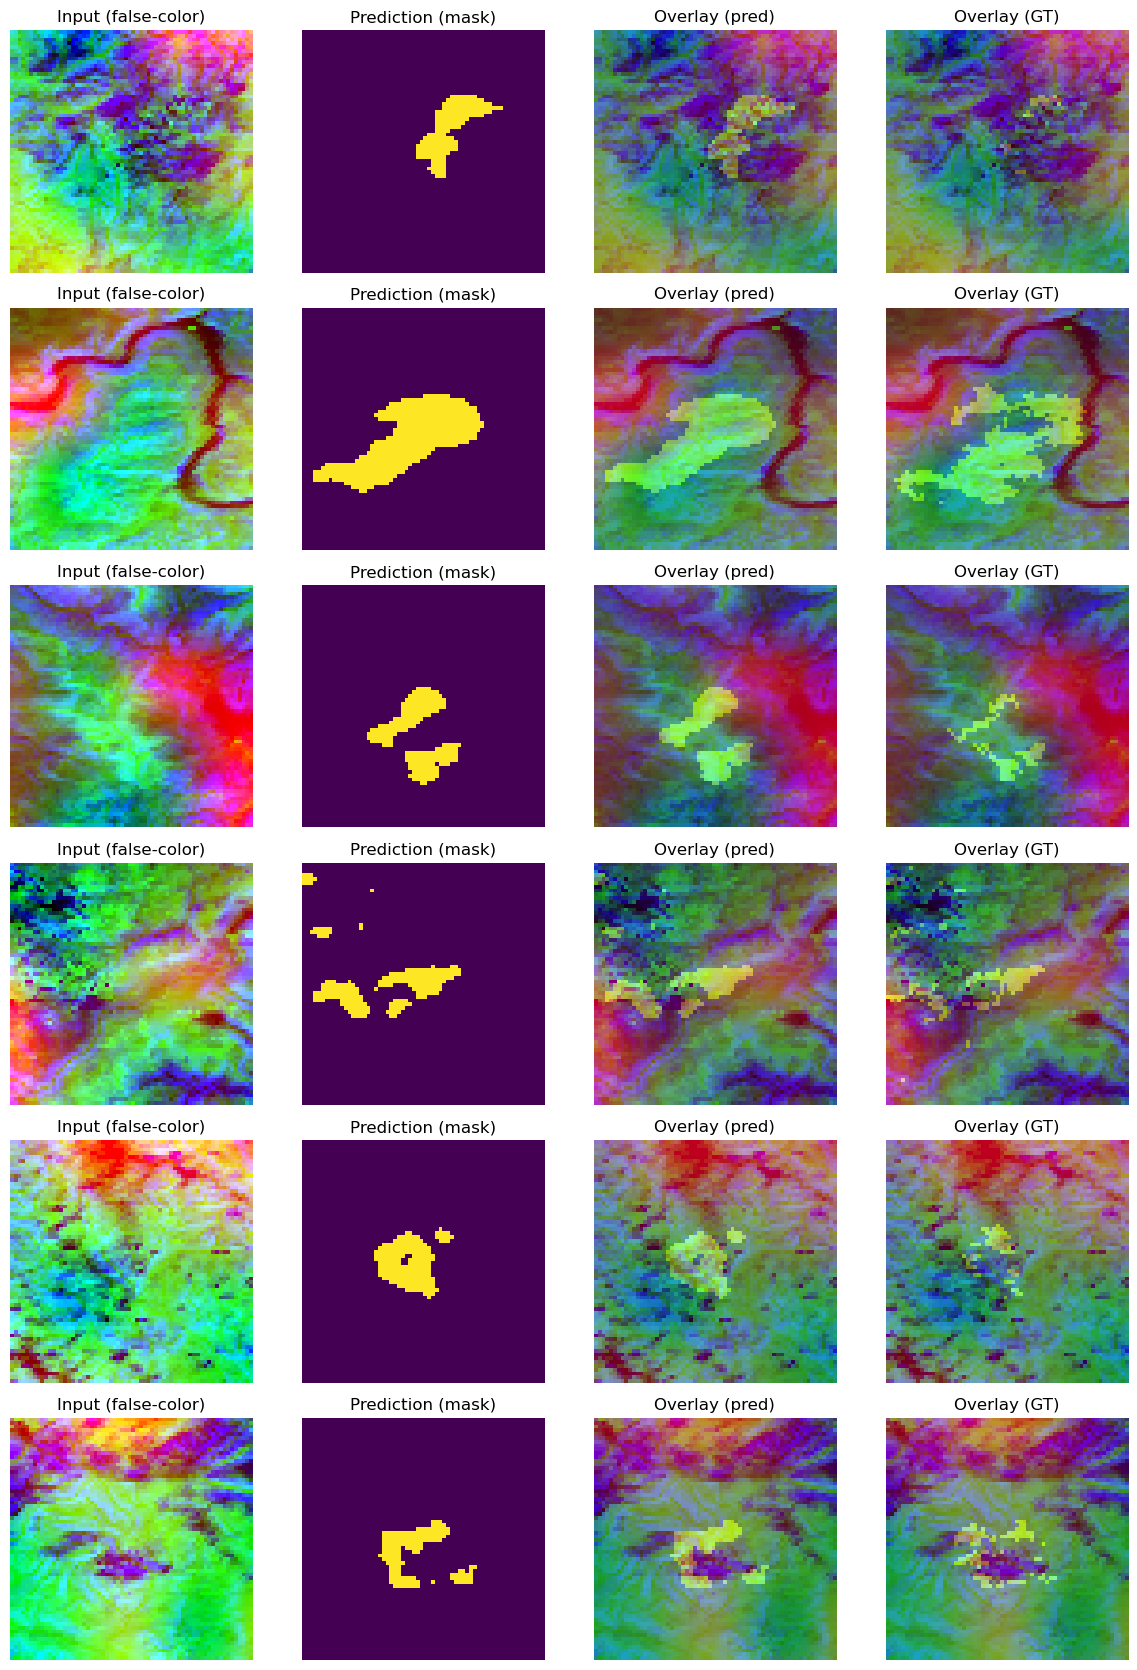

Hard examples (diff view)…


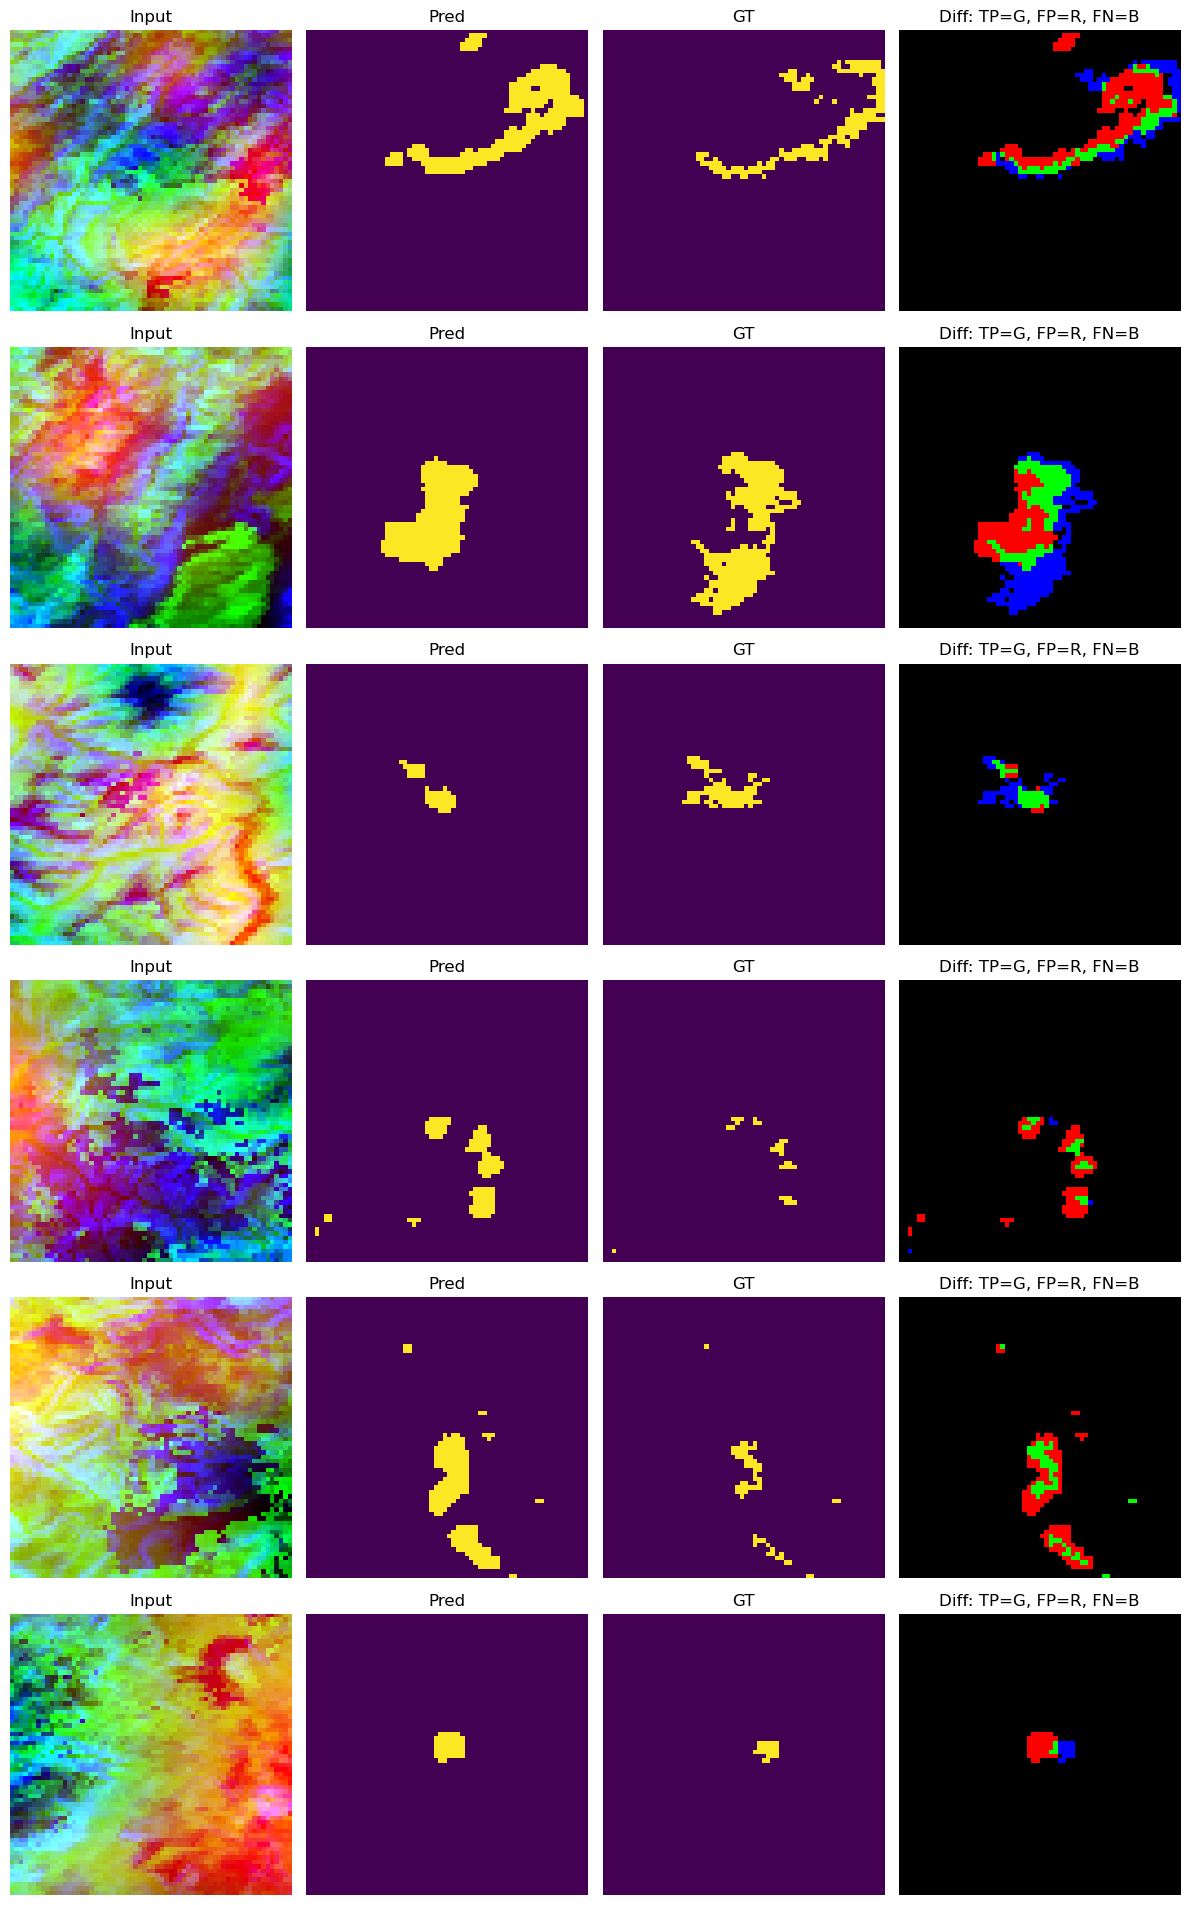

In [36]:
# 1) Where the NPZs live
from pathlib import Path
import shutil

artifact_root = Path(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")))
experiment_dir = artifact_root / "physunet_ema_polyak"
experiment_dir.mkdir(parents=True, exist_ok=True)
deploy_path = experiment_dir / "unet_raw_deploy.pt"
tmp_test_dir = experiment_dir / "npz_test_only"
plain_out_dir = experiment_dir / "preds_plain"
tta_out_dir = experiment_dir / "preds_tta"
tmp_test_dir.mkdir(parents=True, exist_ok=True)
plain_out_dir.mkdir(parents=True, exist_ok=True)
tta_out_dir.mkdir(parents=True, exist_ok=True)

npz_dir = NPZ_ROOT  # flat directory of all .npz
print("Using NPZ root:", npz_dir)
all_npz = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
assert len(all_npz) > 0, f"No .npz found in {npz_dir}."

# 2) Rebuild the same train/val/test split (deterministic)
rng = np.random.default_rng(1337)
idx = np.arange(len(all_npz))
rng.shuffle(idx)

n = len(all_npz)
n_train = int(round(0.70*n))
n_val   = int(round(0.15*n))
test_idx = idx[n_train+n_val:] if (n_train+n_val) < n else idx[-1:]  # guard if tiny

test_files = [all_npz[i] for i in test_idx]
print(f"Split sizes -> train≈{n_train}, val≈{n_val}, test={len(test_files)}")

# 3) Materialize a temp folder with ONLY test files (via symlinks; fallback to copy on Windows)
for p in tmp_test_dir.glob("*.npz"):
    try:
        p.unlink()
    except FileNotFoundError:
        pass

for src in test_files[:]:  # you can slice to make a smaller subset
    dst = tmp_test_dir / os.path.basename(src)
    if dst.exists():
        dst.unlink()
    try:
        os.symlink(src, dst)
    except Exception:
        shutil.copy2(src, dst)

print("Prepared test-only folder:", str(tmp_test_dir), "with", len(list(tmp_test_dir.glob('*.npz'))), "files")

# 4) Load deploy model (weights + thresholds + temperature)
if not deploy_path.exists():
    raise FileNotFoundError(f"Deploy checkpoint not found at {deploy_path}. Run the save-checkpoint cell first.")
try:
    model, thr_plain, thr_tta, T_opt = load_deploy_model(deploy_path)
except ValueError:
    model, thr_plain, thr_tta = load_deploy_model(deploy_path)
    T_opt = 1.0
print(f"Loaded deploy model. thr_plain={thr_plain}  thr_tta={thr_tta}  T={T_opt}")

# 5) Run inference on TEST ONLY
plain_results = infer_folder_npz(
    model,
    npz_dir=str(tmp_test_dir),   # ← test split only
    out_dir=str(plain_out_dir),
    mode="plain",
    threshold=thr_plain,    # or None to save probabilities
    T=T_opt,
    do_clean=True,
    batch_size=32
)

tta_results = infer_folder_npz(
    model,
    npz_dir=str(tmp_test_dir),
    out_dir=str(tta_out_dir),
    mode="tta",
    threshold=thr_tta,      # or None
    T=T_opt,
    do_clean=True,
    batch_size=16
)

# 6) Quick visual sanity checks (optional)
if plain_results:
    print("Showing plain examples…")
    show_examples(plain_results, n=6, add_gt=True, alpha_mask=0.35)

    print("Hard examples (diff view)…")
    show_diff_examples(plain_results, n=6, viz_threshold=thr_plain)

In [37]:
from pathlib import Path
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

# Helper function to load the deployed model
def load_deploy_model(path, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    ckpt = torch.load(path, map_location=device)
    model = UNet(in_ch=ckpt["in_ch"], out_ch=1, base=ckpt["base"]).to(device)

    # Adapt state_dict keys for loading into a potentially uncompiled model
    state_dict = ckpt["model"]
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_state_dict[k[len("_orig_mod."):]] = v
        else:
            new_state_dict[k] = v

    model.load_state_dict(new_state_dict)
    model.eval() # Set to eval mode for inference
    thr_plain = ckpt["thr_plain"]
    thr_tta = ckpt["thr_tta"]
    T_opt = ckpt.get("T", 1.0) # Default to 1.0 if T is not in checkpoint
    return model, thr_plain, thr_tta, T_opt

def _minmax(x, lo_q=2, hi_q=98, eps=1e-6):
    x = x.astype(np.float32)
    lo, hi = np.percentile(x, lo_q), np.percentile(x, hi_q)
    if not np.isfinite(lo) or not np.isfinite(hi) or (hi - lo) < eps:
        return np.zeros_like(x, dtype=np.float32)
    y = (x - lo) / (hi - lo + eps)
    return np.clip(y, 0.0, 1.0)

def make_falsecolor_rgb(X_raw):
    """
    X_raw order: [prev, u, v, temp, rh, ndvi, slope, aspect, barrier]
    Simple composite:
      R = temp, G = NDVI, B = slope
    """
    temp  = X_raw[3]
    ndvi  = X_raw[5]
    slope = X_raw[6]
    R = _minmax(temp)
    G = _minmax(ndvi)
    B = _minmax(slope)
    return np.stack([R, G, B], axis=-1)

def _load_X_raw_from_npz(data):
    """Tolerant loader for X_raw (builds from components if needed)."""
    if "X_raw" in data.files:
        return data["X_raw"].astype(np.float32)
    # Build, allowing missing 'barrier' (zeros default)
    req = ["prev_fire","u","v","temp","rh","ndvi","slope","aspect"]
    missing = [k for k in req if k not in data.files]
    if missing:
        raise KeyError(f"NPZ missing required keys: {missing}")
    barrier = data["barrier"] if "barrier" in data.files else np.zeros_like(data["prev_fire"])
    return np.stack([
        data["prev_fire"], data["u"], data["v"], data["temp"], data["rh"],
        data["ndvi"], data["slope"], data["aspect"], barrier
    ], axis=0).astype(np.float32)

def _binarize_from_result_item(item, viz_threshold=None):
    """
    Returns (mask, is_prob, src_path)
    - If result has 'out_npy': it's a hard mask (0/1).
    - If it has 'out_prob': it's probabilities; apply viz_threshold if given, else return probs.
    """
    if "out_npy" in item:
        pred = np.load(item["out_npy"]).astype(np.float32)
        return pred, False, item["out_npy"]
    if "out_prob" in item:
        prob = np.load(item["out_prob"]).astype(np.float32)
        if viz_threshold is None:
            return prob, True, item["out_prob"]
        return (prob >= float(viz_threshold)).astype(np.float32), False, item["out_prob"]
    raise KeyError("Result item must contain 'out_npy' (mask) or 'out_prob' (probabilities).")

def show_examples(results, n=6, add_gt=True, alpha_mask=0.35, figsize=(12, 2.8), viz_threshold=None):
    """
    results: list of dicts from infer_folder_npz (with 'file', and either 'out_npy' or 'out_prob')
    Shows: input falsecolor, predicted (mask or prob), overlay (+ optional GT overlay)
    - If results contain probabilities ('out_prob') and viz_threshold is None, we show the probability heatmap.
    - If viz_threshold is set, probabilities will be binarized for display.
    """
    if not results:
        print("No results to visualize.")
        return

    picks = random.sample(results, k=min(n, len(results)))
    rows = len(picks)
    # input | pred/prob | overlay | (optional GT overlay)
    cols = 3 + int(add_gt)

    plt.figure(figsize=(figsize[0], figsize[1]*rows))
    idx = 1
    for item in picks:
        npz_path = item["file"]
        data = np.load(npz_path)
        X_raw = _load_X_raw_from_npz(data)
        rgb = make_falsecolor_rgb(X_raw)

        pred_or_prob, is_prob, src = _binarize_from_result_item(item, viz_threshold=viz_threshold)
        H, W = pred_or_prob.shape

        has_gt = add_gt and ("next_fire" in data.files)
        gt = data["next_fire"].astype(np.float32) if has_gt else None

        # Panel 1: Input
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb); ax.set_title("Input (false-color)"); ax.axis("off")

        # Panel 2: Pred (mask or prob heatmap)
        ax = plt.subplot(rows, cols, idx); idx += 1
        if is_prob and viz_threshold is None:
            im = ax.imshow(pred_or_prob, vmin=0, vmax=1)
            ax.set_title("Prediction (probability)")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.imshow(pred_or_prob, vmin=0, vmax=1)
            ax.set_title("Prediction (mask)")
        ax.axis("off")

        # Panel 3: Overlay (pred/prob on input)
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb)
        if is_prob and viz_threshold is None:
            im = ax.imshow(pred_or_prob, alpha=alpha_mask, vmin=0, vmax=1)
            ax.set_title("Overlay (prob)")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.imshow(pred_or_prob, alpha=alpha_mask)
            ax.set_title("Overlay (pred)")
        ax.axis("off")

        # Panel 4: GT overlay (if available)
        if has_gt:
            ax = plt.subplot(rows, cols, idx); idx += 1
            ax.imshow(rgb)
            ax.imshow(gt, alpha=alpha_mask)
            ax.set_title("Overlay (GT)"); ax.axis("off")

    plt.tight_layout()
    plt.show()

def show_diff_examples(results, n=6, alpha=0.35, figsize=(12, 3.2), viz_threshold=None):
    """
    Diff view: TP (green), FP (red), FN (blue)
    Accepts hard masks ('out_npy') OR probabilities ('out_prob'):
      - If 'out_prob' and viz_threshold is None → we’ll set viz_threshold=0.5 for diff.
    """
    if not results:
        print("No results to visualize.")
        return

    picks = random.sample(results, k=min(n, len(results)))
    rows = len(picks); cols = 4  # input | pred | GT | diff

    plt.figure(figsize=(figsize[0], figsize[1]*rows))
    idx = 1
    for item in picks:
        npz_path = item["file"]
        data = np.load(npz_path)
        if "next_fire" not in data.files:
            # skip if no GT
            continue

        X_raw = _load_X_raw_from_npz(data)
        rgb = make_falsecolor_rgb(X_raw)
        gt = data["next_fire"].astype(np.float32)

        # Threshold handling for probs
        thr = 0.5 if ("out_prob" in item and viz_threshold is None) else viz_threshold
        pred, is_prob, src = _binarize_from_result_item(item, viz_threshold=thr)
        if is_prob:
            # shouldn’t happen due to viz_threshold above, but guard anyway
            pred = (pred >= 0.5).astype(np.float32)

        # Diff map
        tp = (pred==1) & (gt==1)
        fp = (pred==1) & (gt==0)
        fn = (pred==0) & (gt==1)
        diff_rgb = np.zeros((*gt.shape, 3), dtype=np.float32)
        diff_rgb[...,1] = tp.astype(np.float32)  # G
        diff_rgb[...,0] = fp.astype(np.float32)  # R
        diff_rgb[...,2] = fn.astype(np.float32)  # B

        # 1) Input
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(rgb); ax.set_title("Input"); ax.axis("off")

        # 2) Pred
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(pred, vmin=0, vmax=1); ax.set_title("Pred"); ax.axis("off")

        # 3) GT
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(gt, vmin=0, vmax=1); ax.set_title("GT"); ax.axis("off")

        # 4) Diff
        ax = plt.subplot(rows, cols, idx); idx += 1
        ax.imshow(diff_rgb); ax.set_title("Diff: TP=G, FP=R, FN=B"); ax.axis("off")

    plt.tight_layout()
    plt.show()


In [39]:
from pathlib import Path
import os

artifact_root = Path(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts"))) / "physunet_ema_polyak"
artifact_root.mkdir(parents=True, exist_ok=True)
deploy_path = artifact_root / "unet_raw_deploy.pt"
plain_out_dir = artifact_root / "preds_plain"
tta_out_dir = artifact_root / "preds_tta"
plain_out_dir.mkdir(parents=True, exist_ok=True)
tta_out_dir.mkdir(parents=True, exist_ok=True)

if not deploy_path.exists():
    raise FileNotFoundError(f"Deploy checkpoint not found at {deploy_path}. Run the save-checkpoint cell first.")

loaded = load_deploy_model(deploy_path)
if isinstance(loaded, (list, tuple)) and len(loaded) == 4:
    model, thr_plain, thr_tta, T_opt = loaded
elif isinstance(loaded, (list, tuple)) and len(loaded) == 3:
    model, thr_plain, thr_tta = loaded
    T_opt = 1.0
else:
    raise ValueError("Unexpected return payload from load_deploy_model")

plain_results = infer_folder_npz(
    model, npz_dir=npz_dir, out_dir=str(plain_out_dir),
    mode="plain", threshold=thr_plain, T=T_opt, do_clean=True, batch_size=32
)
tta_results = infer_folder_npz(
    model, npz_dir=npz_dir, out_dir=str(tta_out_dir),
    mode="tta", threshold=thr_tta, T=T_opt, do_clean=True, batch_size=16
)

Inferring (plain):   0%|          | 0/629 [00:00<?, ?it/s]

Inferring (tta):   0%|          | 0/1257 [00:00<?, ?it/s]

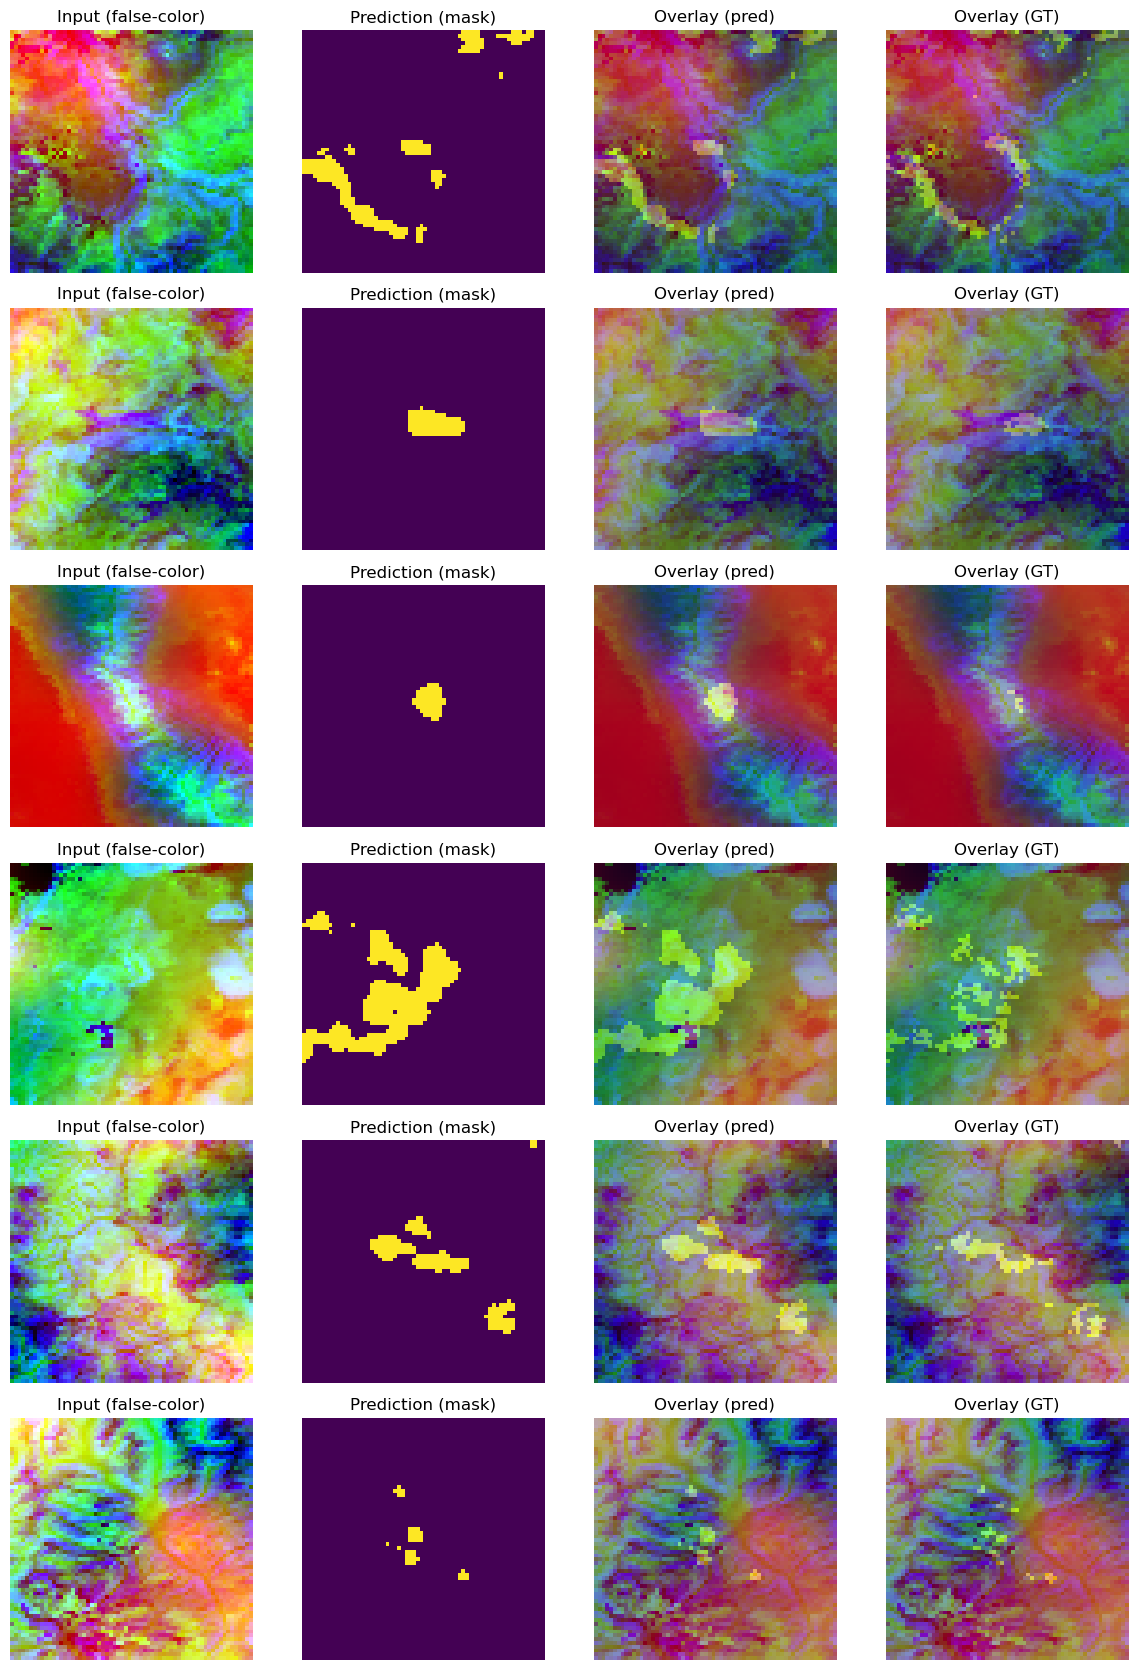

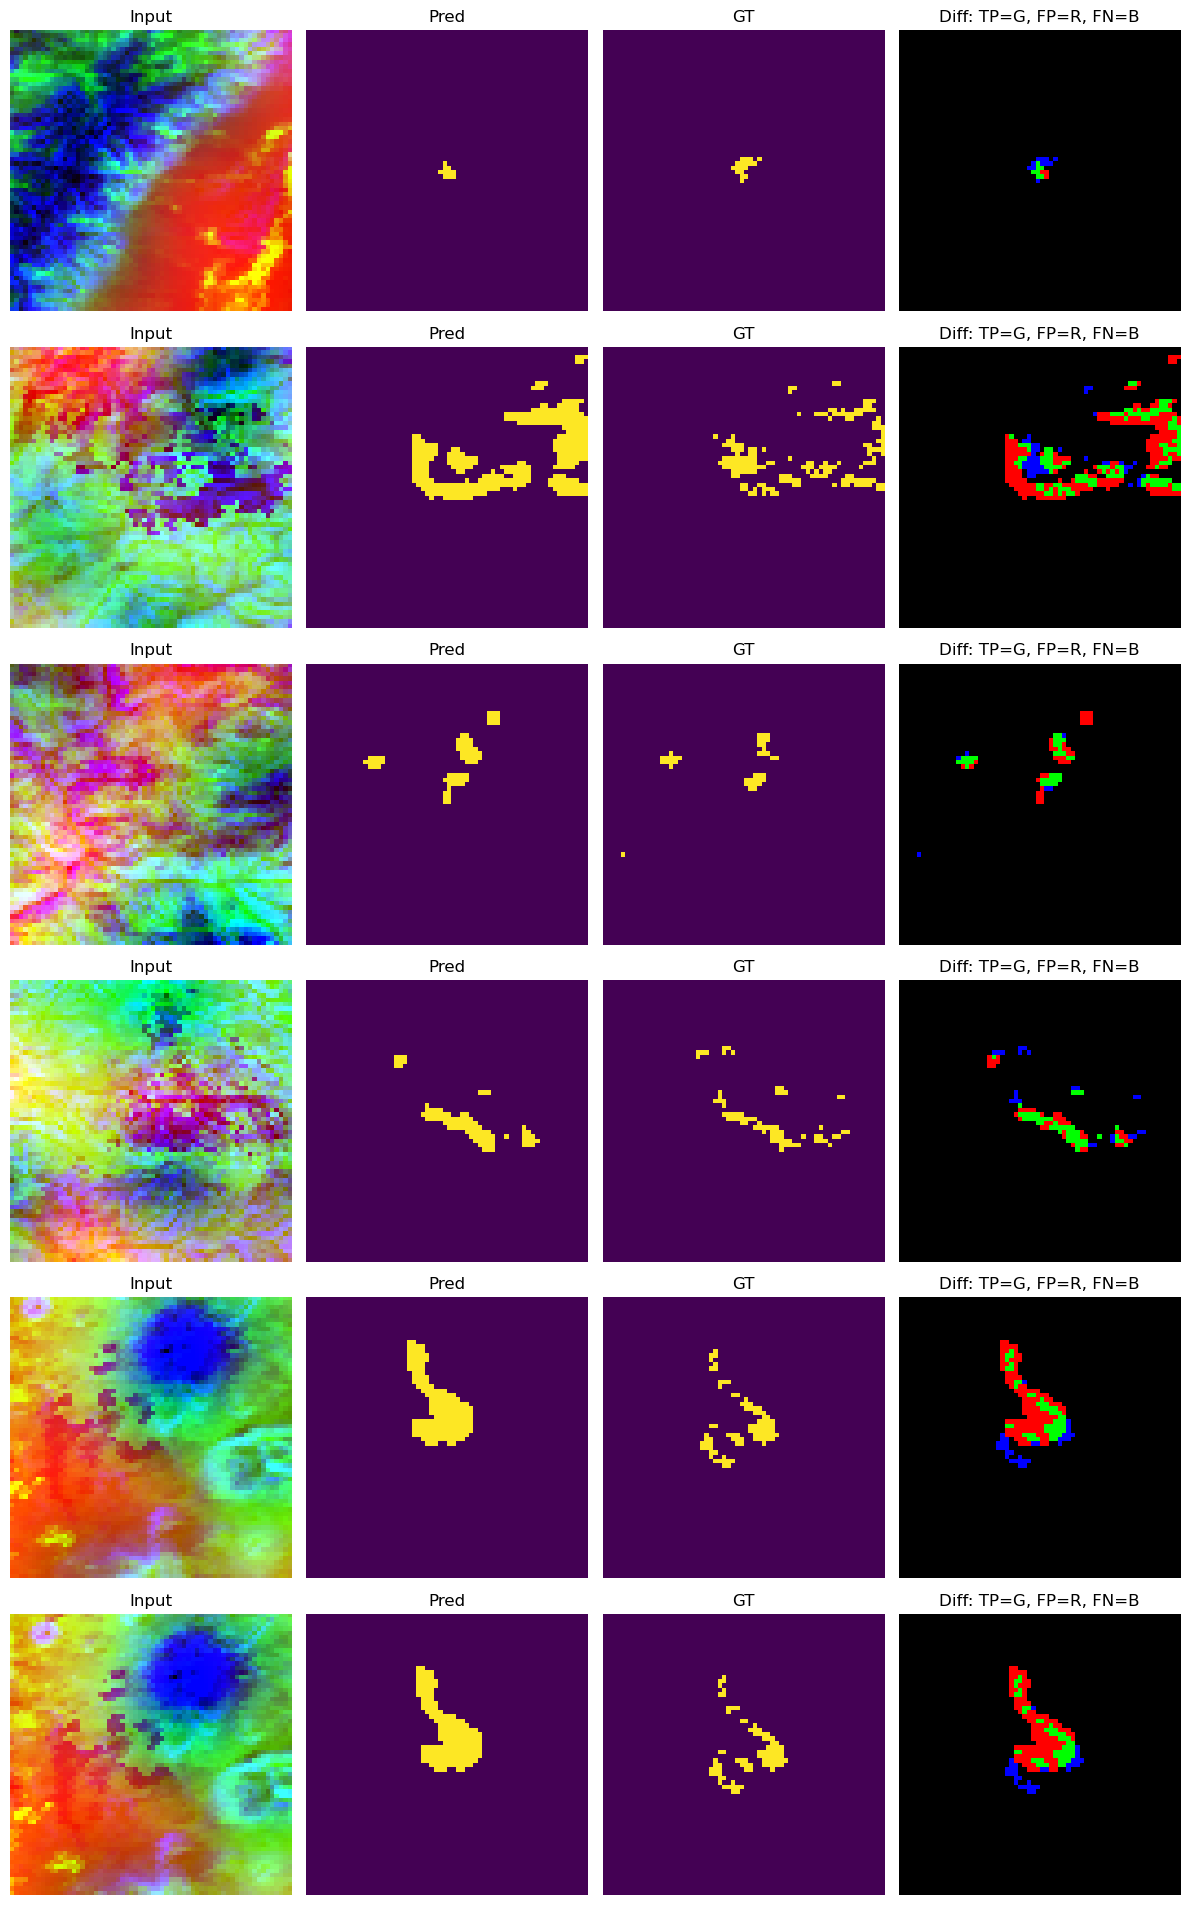

In [40]:
show_examples(plain_results, viz_threshold=None)  # heatmaps
show_diff_examples(plain_results, viz_threshold=0.3)  # binarize at 0.3 to see diffs


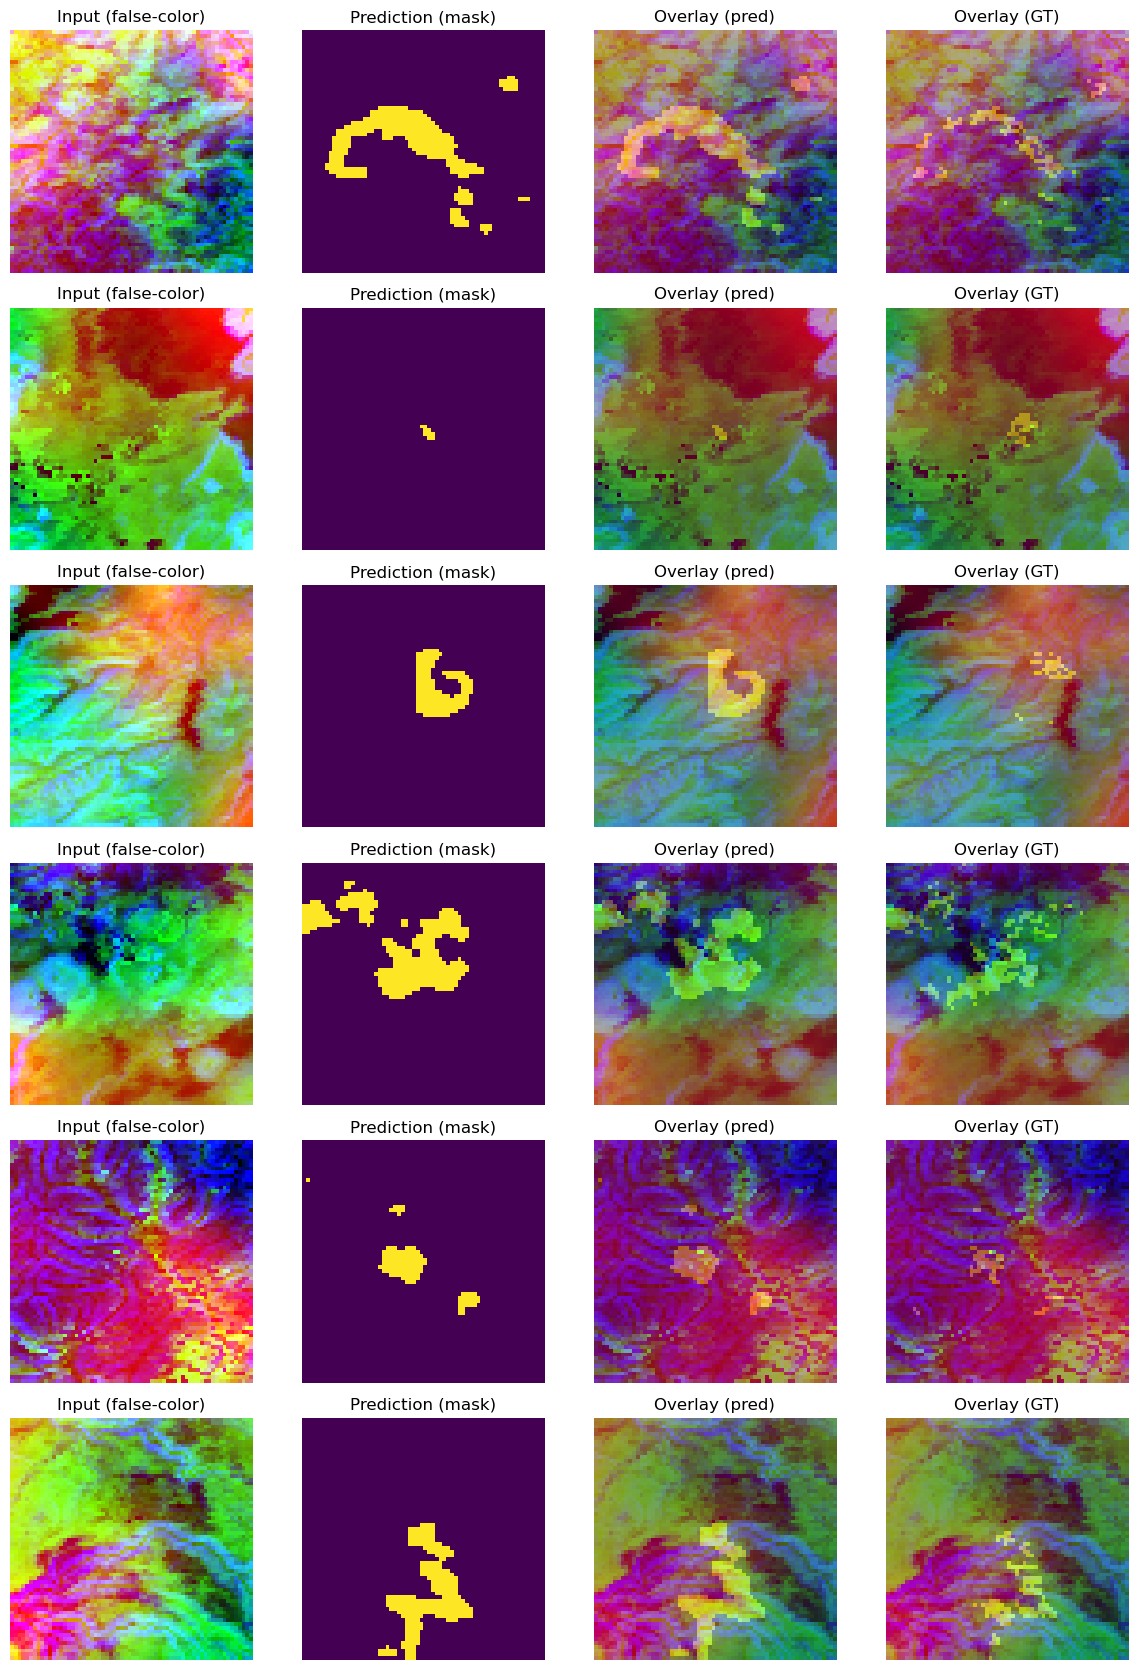

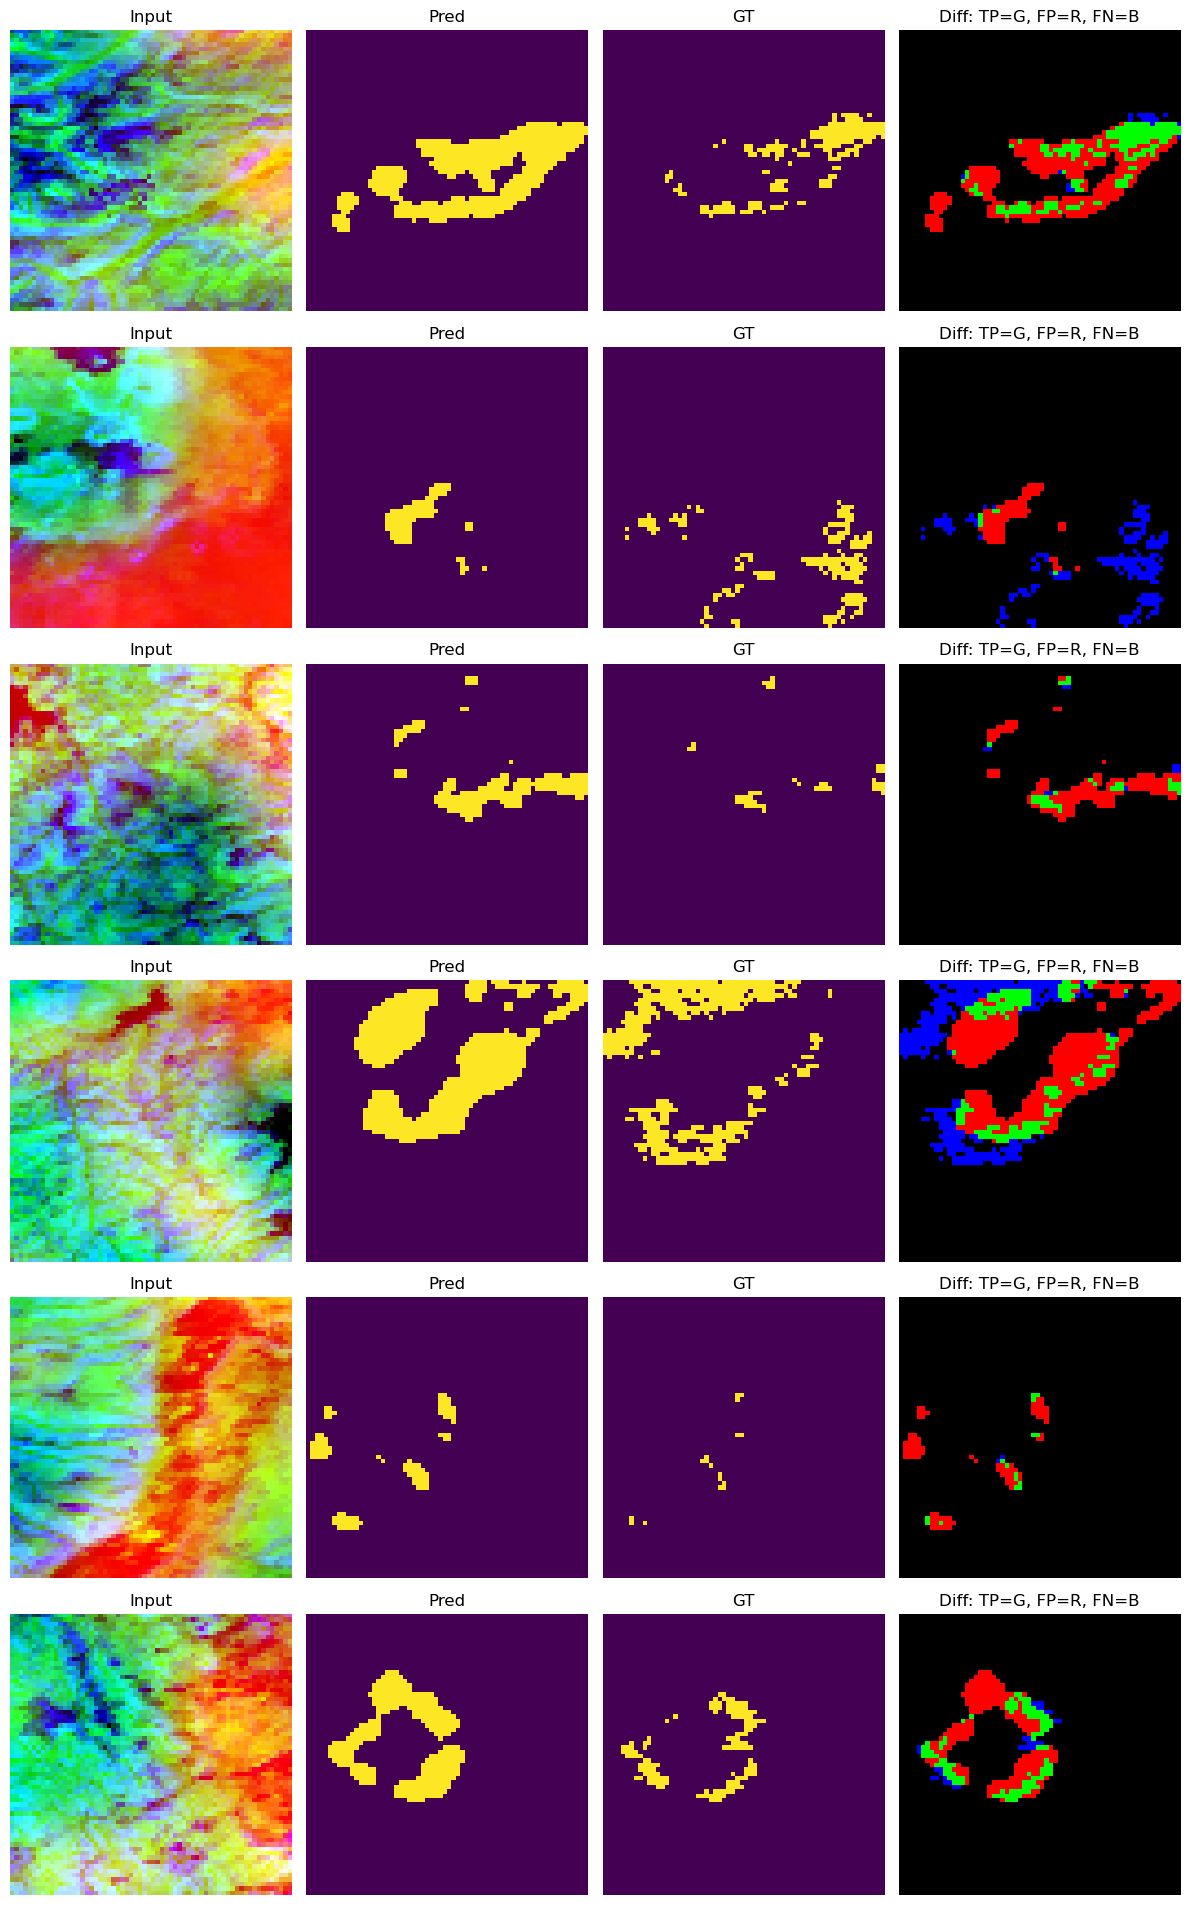

In [41]:
show_examples(plain_results)
show_diff_examples(plain_results)


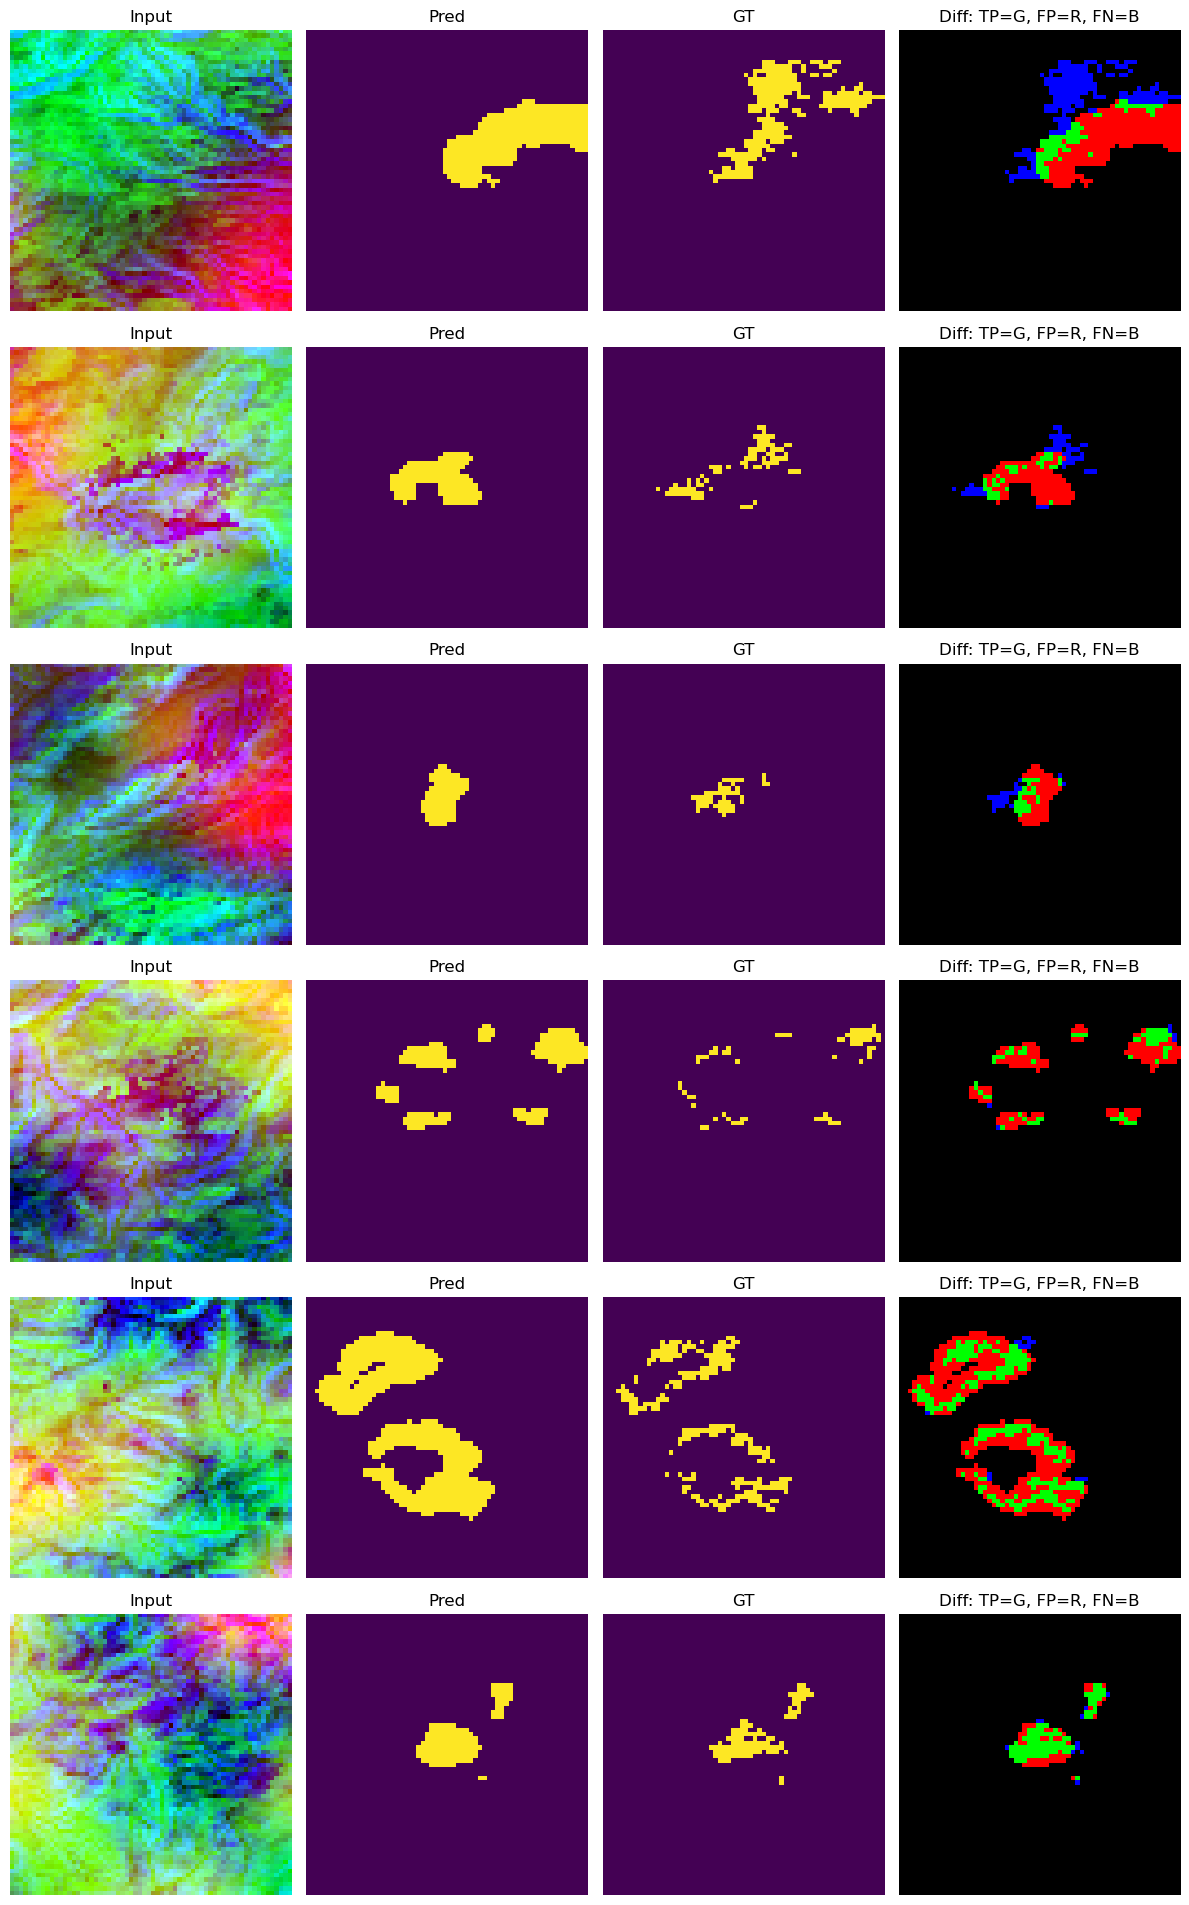

In [42]:
show_diff_examples(plain_results, viz_threshold=None)

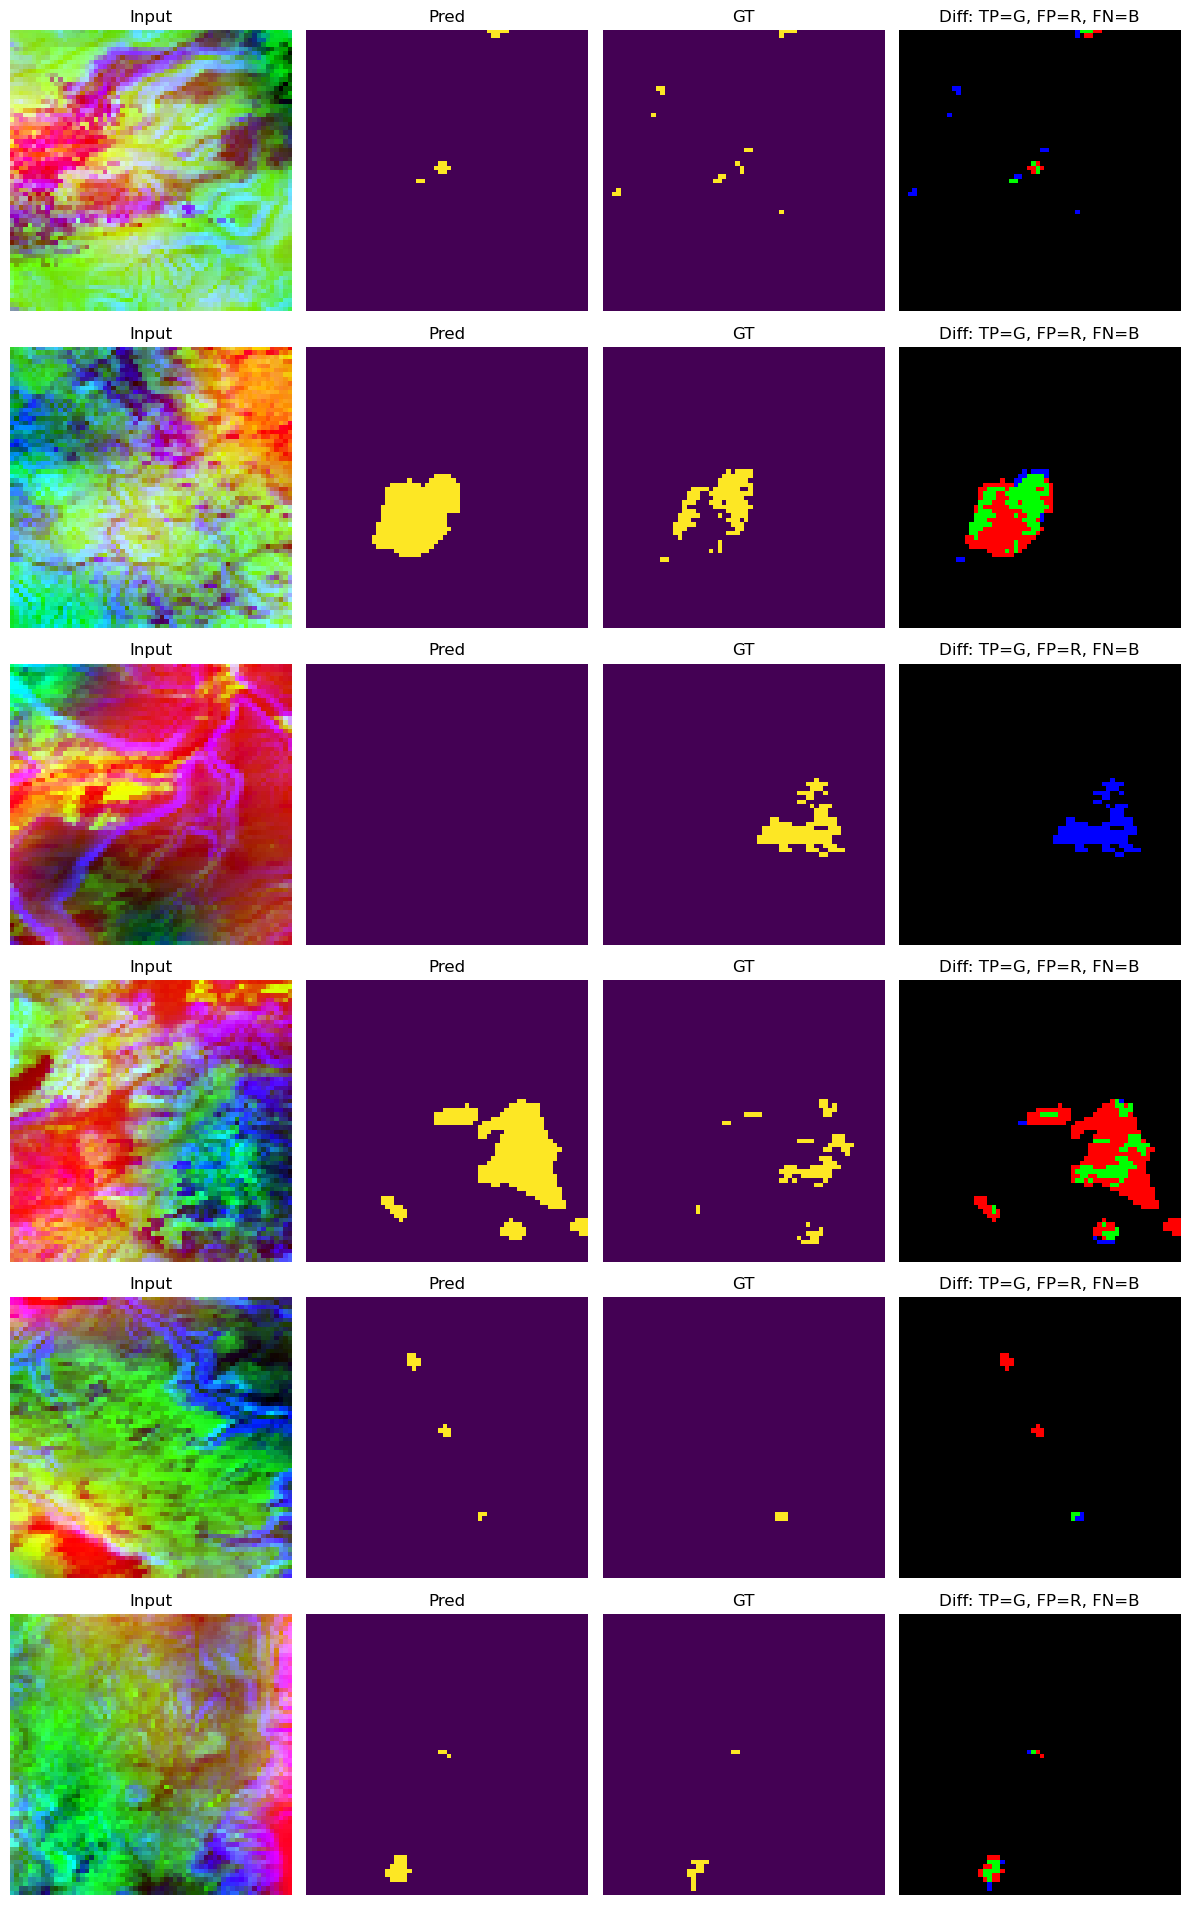

In [43]:
show_diff_examples(plain_results, viz_threshold=0.12)  # pick your viz cutoff

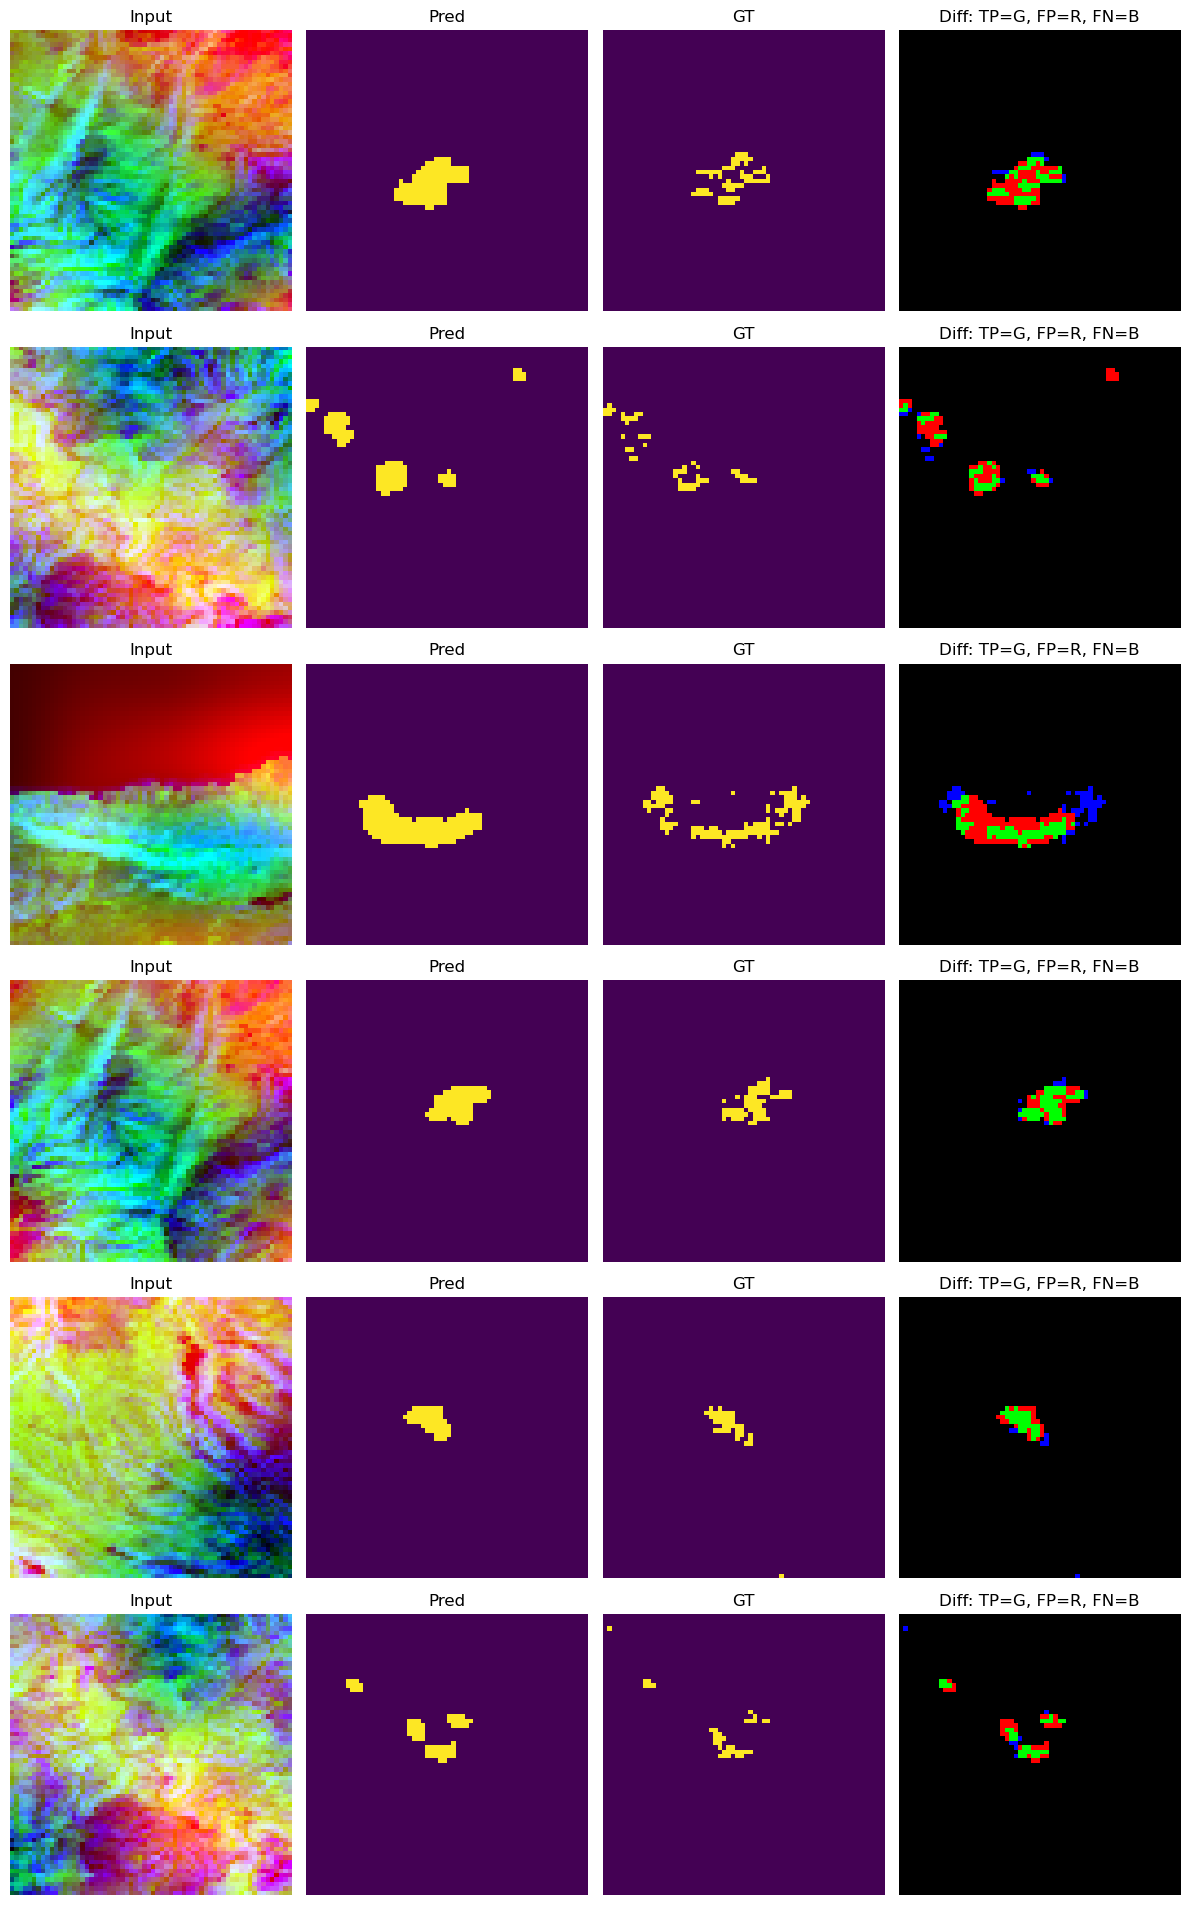

In [44]:
show_diff_examples(tta_results, n=6, viz_threshold=None)


In [46]:
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve

def aggregate_metrics(results,
                      threshold=None,
                      bins=(0,5,20,100,4096),
                      pred_key_preference=("out_prob","out_npy")):
    """
    results: list from infer_folder_npz (each item has 'file' and one of pred_key_preference)
    threshold:
      - float -> use this threshold to binarize for F1/by-bin
      - None  -> auto-pick best-F1 threshold from PR curve (if probs available),
                 otherwise use 0.5 on binary masks
    bins: GT pixel-count bins for per-tile F1 summaries
    pred_key_preference: try these keys in order to load predictions
                         ('out_prob' preferred, fallback to 'out_npy')
    Returns:
      best: dict(AP, best_F1, best_thr, best_prec, best_rec)
      bybin_mean: {(lo,hi): mean F1}, counts: {(lo,hi): n_tiles}
    """
    all_p, all_t = [], []
    bybin = { (bins[i], bins[i+1]): [] for i in range(len(bins)-1) }
    counts = { k: 0 for k in bybin }

    # First pass: collect concatenated probs (or binaries) for global PR/AP
    cache = []  # keep (gt, pred_probs_or_bin, path) to avoid reloading twice
    for r in results:
        d = np.load(r["file"])
        if "next_fire" not in d.files:
            # skip tiles with no GT
            continue
        gt = d["next_fire"].astype(np.float32)

        # choose available prediction file
        pred_path = None
        for k in pred_key_preference:
            if k in r:
                pred_path = r[k]
                break
        if pred_path is None:
            # fallback to legacy key
            pred_path = r.get("out_npy", None)
        if pred_path is None:
            continue

        pred_arr = np.load(pred_path).astype(np.float32)  # probs or binary
        # If it's a PNG-derived mask you loaded elsewhere, ensure shape match here.

        cache.append((gt, pred_arr, r["file"]))
        all_t.append(gt.ravel())
        all_p.append(pred_arr.ravel())

    if not all_p:
        return {"AP": float("nan"), "best_F1": float("nan"),
                "best_thr": float("nan"), "best_prec": float("nan"), "best_rec": float("nan")}, \
               {k: float("nan") for k in bybin}, {k: 0 for k in counts}

    t = np.concatenate(all_t)
    p = np.concatenate(all_p)

    # Global PR/AP on whatever we have (probs preferred; binaries okay but lower-bound)
    ap = float(average_precision_score(t, p))
    prec, rec, thr = precision_recall_curve(t, p)
    f1_curve = (2*prec*rec)/(prec+rec+1e-8)
    best_idx = int(f1_curve.argmax())

    # Decide threshold to use for per-bin F1
    if threshold is None:
        auto_thr = float(thr[min(best_idx, len(thr)-1)]) if len(thr) > 0 else 0.5
        use_thr = auto_thr
    else:
        use_thr = float(threshold)

    best = {
        "AP": ap,
        "best_F1": float(f1_curve[best_idx]),
        "best_thr": float(thr[min(best_idx, len(thr)-1)]) if len(thr) > 0 else 0.5,
        "best_prec": float(prec[best_idx]),
        "best_rec": float(rec[best_idx]),
        "used_thr_for_bins": use_thr
    }

    # Second pass: per-tile F1 in GT-size bins using chosen threshold
    for gt, pred_arr, _ in cache:
        k = int(gt.sum())
        pred_bin = (pred_arr >= use_thr).astype(np.float32) if pred_arr.max() <= 1.0 and pred_arr.min() < 1.0 else (pred_arr > 0.5).astype(np.float32)
        # (if pred_arr is {0,1}, the expression above still works)

        for lo, hi in bybin.keys():
            if lo <= k < hi:
                tp = (pred_bin*gt).sum()
                fp = (pred_bin*(1-gt)).sum()
                fn = ((1-pred_bin)*gt).sum()
                prec_b = tp/(tp+fp+1e-8); rec_b = tp/(tp+fn+1e-8)
                f1_b   = 2*prec_b*rec_b/(prec_b+rec_b+1e-8)
                bybin[(lo,hi)].append(float(f1_b))
                counts[(lo,hi)] += 1
                break

    bybin_mean = {k: (float(np.mean(v)) if v else float("nan")) for k,v in bybin.items()}
    return best, bybin_mean, counts


In [47]:
best_plain, bins_plain, counts_plain = aggregate_metrics(plain_results, threshold=None)
print("GLOBAL (plain):", best_plain)
print("F1 by GT size:", bins_plain)
print("Counts per bin:", counts_plain)

# If you have probability maps (e.g., saved via threshold=None in infer),
# you can lock a threshold explicitly:
# best_tta, bins_tta, counts_tta = aggregate_metrics(tta_results, threshold=thr_tta)


GLOBAL (plain): {'AP': 0.41214615787314063, 'best_F1': 0.46888310179688963, 'best_thr': 0.3365527391433716, 'best_prec': 0.41565834721849887, 'best_rec': 0.5377403854888742, 'used_thr_for_bins': 0.3365527391433716}
F1 by GT size: {(0, 5): nan, (5, 20): 0.30602698857566657, (20, 100): 0.4166191097999537, (100, 4096): 0.47847742964317924}
Counts per bin: {(0, 5): 0, (5, 20): 4394, (20, 100): 7707, (100, 4096): 7996}
